In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Imports
import warnings
warnings.filterwarnings('ignore')

import sys

if "google.colab" in sys.modules:
    !pip uninstall lightgbm -y
    !pip install lightgbm==3.3.1
    !pip install Levenshtein

import os
import gc
import time
import random
import pickle
import Levenshtein
import difflib
import multiprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
from tqdm.auto import tqdm
from requests import get
from collections import Counter, defaultdict
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

Found existing installation: lightgbm 3.3.1
Uninstalling lightgbm-3.3.1:
  Successfully uninstalled lightgbm-3.3.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached lightgbm-3.3.1-py3-none-manylinux1_x86_64.whl (2.0 MB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [ ]:
def get_distribution(y_vals):
    y_distr = Counter(y_vals)
    y_vals_sum = sum(y_distr.values())
    return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]

In [ ]:
## Parameters
class CFG:
    AUTHOR = "kuruton"
    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]
    ROOT_DIR = '/content/drive/MyDrive/Kaggle/Foursquare'
    DATASET_DIR = os.path.join(ROOT_DIR, 'Dataset')
    INPUT_DIR = os.path.join(ROOT_DIR, 'Input')
    OUTPUT_DIR = os.path.join(ROOT_DIR, 'Output')
    is_debug = False
    SEED = 2022
    num_neighbors = 20
    num_split = 5
    feat_columns = ['name', 'address', 'city', 
                'state', 'zip', 'categories']
    vec_columns = ['name', 'categories', 'address', 
                  'state']

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(CFG.SEED)

In [ ]:
if not os.path.exists(os.path.join(CFG.OUTPUT_DIR, CFG.expID)):
    os.makedirs(os.path.join(CFG.OUTPUT_DIR, CFG.expID))

In [ ]:
%load_ext Cython

In [ ]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [ ]:
def recall_knn(df, Neighbors = 10):
    print('Start knn')
    train_df = []
    knn = KNeighborsRegressor(n_neighbors = Neighbors,
                              metric = 'haversine',
                              n_jobs = -1)
    knn.fit(df[['latitude','longitude']], df.index)
    dists, nears = knn.kneighbors(df[['latitude','longitude']])
    
    for k in range(Neighbors):            
        cur_df = df[['id']]
        cur_df['match_id'] = df['id'].values[nears[:, k]]
        cur_df['kdist'] = dists[:, k]
        cur_df['kneighbors'] = k
        train_df.append(cur_df)
    
    train_df = pd.concat(train_df)
    train_df = train_df.reset_index()
    
    return train_df

In [ ]:
def add_features(df, set_num):    
    for col in tqdm(CFG.feat_columns):       
        if col in CFG.vec_columns:
            tv_fit = tfidf_d[col]
            indexs = [id2index_d[i] for i in df['id']]
            match_indexs = [id2index_d[i] for i in df['match_id']]                    
            df[f'{col}_sim'] = tv_fit[indexs].multiply(tv_fit[match_indexs]).sum(axis = 1).A.ravel()
        
        col_values = data.loc[df['id']][col].values.astype(str)
        matcol_values = data.loc[df['match_id']][col].values.astype(str)
        vc = data.loc[data['set'] == set_num, col].value_counts() / sum(data['set'] == set_num)
        geshs = []
        levens = []
        jaros = []
        lcss = []
        vc1 = []
        vc2 = []

        for s, match_s in zip(col_values, matcol_values):
            if s != 'nan':
                vc1.append(vc[s])
            else:
                vc1.append(np.nan)

            if match_s != 'nan':
                vc2.append(vc[match_s])
            else:
                vc2.append(np.nan)

            if s != 'nan' and match_s != 'nan':                    
                geshs.append(difflib.SequenceMatcher(None, s, match_s).ratio())
                levens.append(Levenshtein.distance(s, match_s))
                jaros.append(Levenshtein.jaro_winkler(s, match_s))
                lcss.append(LCS(str(s), str(match_s)))
            else:
                geshs.append(np.nan)
                levens.append(np.nan)
                jaros.append(np.nan)
                lcss.append(np.nan)
        
        df[f'{col}_gesh'] = geshs
        df[f'{col}_leven'] = levens
        df[f'{col}_jaro'] = jaros
        df[f'{col}_lcs'] = lcss
        df[f'{col}_CE_1'] = vc1
        df[f'{col}_CE_2'] = vc2
        
        if col not in ['phone', 'zip']:
            df[f'{col}_len'] = list(map(len, col_values))
            df[f'match_{col}_len'] = list(map(len, matcol_values)) 
            df[f'{col}_len_diff'] = np.abs(df[f'{col}_len'] - df[f'match_{col}_len'])
            df[f'{col}_nleven'] = df[f'{col}_leven'] / \
                                    df[[f'{col}_len', f'match_{col}_len']].max(axis = 1)
            
            df[f'{col}_nlcsk'] = df[f'{col}_lcs'] / df[f'match_{col}_len']
            df[f'{col}_nlcs'] = df[f'{col}_lcs'] / df[f'{col}_len']
            
            df = df.drop(f'{col}_len', axis = 1)
            df = df.drop(f'match_{col}_len', axis = 1)
            gc.collect()
    return df

In [ ]:
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

def get_score(input_df: pd.DataFrame):
    scores = []
    for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
        targets = poi2ids[id2poi[id_str]]
        preds = set(matches.split())
        score = len((targets & preds)) / len((targets | preds))
        scores.append(score)
    scores = np.array(scores)
    return scores.mean()

def analysis(df):
    print('Num of data: %s' % len(df))
    print('Num of unique id: %s' % df['id'].nunique())
    print('Num of unique poi: %s' % df['point_of_interest'].nunique())
    
    poi_grouped = df.groupby('point_of_interest')['id'].count().reset_index()
    print('Mean num of unique poi: %s' % poi_grouped['id'].mean())

In [ ]:
## Data load
if "google.colab" in sys.modules:
    data_root = CFG.INPUT_DIR
else:
    data_root = '../input/foursquare-location-matching'
data = pd.read_csv(os.path.join(data_root, 'train.csv'))

if CFG.is_debug:
    data = data.sample(n = 10000, random_state = CFG.SEED)
    data = data.reset_index(drop = True)

In [ ]:
data['POI_count'] = data['point_of_interest'].map(dict(data.groupby('point_of_interest')['id'].apply(len)))
data.loc[data['POI_count'] > 5, 'POI_count'] = 5
data['POI_count'] -= 1
data.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e,1
1,E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83,1
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477,0
3,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3,0
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb,1


In [ ]:
distrs = [get_distribution(data['POI_count'])]
index = ['training set']

for set_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(data, data['POI_count'], data["point_of_interest"], k=2, seed=CFG.SEED)):
    data.loc[val_ind, "set"] = set_ind

    dev_y, val_y = data.loc[dev_ind, 'POI_count'], data.loc[val_ind, 'POI_count']
    dev_groups, val_groups = data.loc[dev_ind, "point_of_interest"], data.loc[val_ind, "point_of_interest"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - set {set_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - set {set_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(data['POI_count']) + 1)])

'Distribution per class:'

,Label 0,Label 1,Label 2,Label 3,Label 4
training set,37.32%,48.77%,6.38%,2.09%,5.44%
development set - set 0,37.32%,48.77%,6.38%,2.08%,5.44%
validation set - set 0,37.32%,48.77%,6.38%,2.09%,5.44%
development set - set 1,37.32%,48.77%,6.38%,2.09%,5.44%
validation set - set 1,37.32%,48.77%,6.38%,2.08%,5.44%


In [ ]:
# Data split
print('Num of train data: %s' % len(data))
print(data['set'].value_counts())

train_data = data.loc[data['set'] == 0]
test_data = data.loc[data['set'] == 1]

print('Train data: ')
analysis(train_data)
print('Test data: ')
analysis(test_data)

train_poi = train_data['point_of_interest'].unique().tolist()
test_poi = test_data['point_of_interest'].unique().tolist()

print(set(train_poi) & set(test_poi))

train_ids = train_data['id'].unique().tolist()
test_ids = test_data['id'].unique().tolist()
      
print(set(train_ids) & set(test_ids))
      
tv_ids_d = {}
tv_ids_d['train_ids'] = train_ids
tv_ids_d['test_ids'] = test_ids

np.save('tv_ids_d.npy', tv_ids_d)

del train_data, test_data
gc.collect()

data = data.set_index('id')
data = data.reset_index()

Num of train data: 1138812
0.0    569408
1.0    569404
Name: set, dtype: int64
Train data: 
Num of data: 569408
Num of unique id: 569408
Num of unique poi: 369986
Mean num of unique poi: 1.538998772926543
Test data: 
Num of data: 569404
Num of unique id: 569404
Num of unique poi: 369986
Mean num of unique poi: 1.538987961706659
set()
set()


In [ ]:
## Train data generated by knn
id2index_d = dict(zip(data['id'].values, data.index))

tfidf_d = {}
for col in CFG.vec_columns:
    tfidf = TfidfVectorizer()
    tfidf.fit(data[col].fillna('nan'))
    tv_fit = tfidf.transform(data[col].fillna('nan'))
    tfidf_d[col] = tv_fit

train_data = recall_knn(data.loc[data['set'] == 0], CFG.num_neighbors)
test_data = recall_knn(data.loc[data['set'] == 1], CFG.num_neighbors)

data = data.set_index('id')
ids = train_data['id'].tolist()
match_ids = train_data['match_id'].tolist()

poi = data.loc[ids]['point_of_interest'].values
match_poi = data.loc[match_ids]['point_of_interest'].values

train_data['label'] = np.array(poi == match_poi, dtype = np.int8)

test_ids = test_data['id'].tolist()
test_match_ids = test_data['match_id'].tolist()

test_poi = data.loc[test_ids]['point_of_interest'].values
test_match_poi = data.loc[test_match_ids]['point_of_interest'].values

test_data['label'] = np.array(test_poi == test_match_poi, dtype = np.int8)
del poi, match_poi, ids, match_ids, test_poi, test_match_poi, test_ids, test_match_ids
gc.collect()

print('Num of unique id: %s' % train_data['id'].nunique())
print('Num of train data: %s' % len(train_data))
print('Pos rate: %s' % train_data['label'].mean())
print(train_data.sample(5))

Start knn
Start knn
Num of unique id: 569408
Num of train data: 11388160
Pos rate: 0.08497781906822524
           index                id          match_id     kdist  kneighbors  \
3758063   683961  E_99a140a34f285e  E_144fc85b10cf53  0.003638           6   
4129113   286764  E_405f9c2c763e2a  E_0cfb4c852aec4f  0.000526           7   
4251869   532418  E_77a7261e5e52fa  E_e9f5c8e7e65b69  0.003145           7   
10838572   39651  E_08e1f8e863777c  E_07fe916b5379e8  0.005867          19   
348480    697719  E_9cb61b103c9671  E_9cb61b103c9671  0.000000           0   

          label  
3758063       0  
4129113       0  
4251869       0  
10838572      0  
348480        1  


In [ ]:
## Eval
data = data.reset_index()

id2poi = get_id2poi(data)
poi2ids = get_poi2ids(data)

eval_df = pd.DataFrame()
eval_df['id'] = data['id'].unique().tolist()
eval_df['match_id'] = eval_df['id']
print('Unique id: %s' % len(eval_df))

eval_df_ = train_data[train_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df_ = test_data[test_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df = eval_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
eval_df['matches'] = eval_df['match_id'].apply(lambda x: ' '.join(set(x)))
print('Unique id: %s' % len(eval_df))

iou_score = get_score(eval_df)
print('IoU score: %s' % iou_score)

Unique id: 1138812
Unique id: 1138812
IoU score: 0.9009407382499949


In [ ]:
distrs = [get_distribution(train_data["label"])]
index = ['training set']

for fold_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(train_data, train_data["label"], train_data["id"], k=CFG.num_split, seed=CFG.SEED)):
    train_data.loc[val_ind, "fold"] = fold_ind

    dev_y, val_y = train_data.loc[dev_ind, "label"], train_data.loc[val_ind, "label"]
    dev_groups, val_groups = train_data.loc[dev_ind, "id"], train_data.loc[val_ind, "id"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - fold {fold_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - fold {fold_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(train_data["label"]) + 1)])

'Distribution per class:'

,Label 0,Label 1
training set,91.50%,8.50%
development set - fold 0,91.50%,8.50%
validation set - fold 0,91.50%,8.50%
development set - fold 1,91.50%,8.50%
validation set - fold 1,91.50%,8.50%
development set - fold 2,91.50%,8.50%
validation set - fold 2,91.50%,8.50%
development set - fold 3,91.50%,8.50%
validation set - fold 3,91.50%,8.50%
development set - fold 4,91.50%,8.50%


# model learning

In [ ]:
data = data.set_index('id')
train_data = add_features(train_data, 0)

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
features = ['kdist','kneighbors']

columns = ['name', 'address', 'city', 'state',
       'zip', 'categories']

for c in columns:
    if c == 'country':
        features += ['country_leven', 'country_sim', 'country_gesh', 'country_nleven']
        continue
    features += [f"{c}_gesh", f"{c}_jaro", f"{c}_lcs", f"{c}_leven"]
    if c == 'city':
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs"]
    if c in ['address', 'categories', 'country', 'name', 'state', 'url']:
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs", f"{c}_sim"]

for c in CFG.feat_columns:
    features += [c + "_CE_1", c + "_CE_2"]

print(len(features))
print(features)

62
['kdist', 'kneighbors', 'name_gesh', 'name_jaro', 'name_lcs', 'name_leven', 'name_len_diff', 'name_nleven', 'name_nlcsk', 'name_nlcs', 'name_sim', 'address_gesh', 'address_jaro', 'address_lcs', 'address_leven', 'address_len_diff', 'address_nleven', 'address_nlcsk', 'address_nlcs', 'address_sim', 'city_gesh', 'city_jaro', 'city_lcs', 'city_leven', 'city_len_diff', 'city_nleven', 'city_nlcsk', 'city_nlcs', 'state_gesh', 'state_jaro', 'state_lcs', 'state_leven', 'state_len_diff', 'state_nleven', 'state_nlcsk', 'state_nlcs', 'state_sim', 'zip_gesh', 'zip_jaro', 'zip_lcs', 'zip_leven', 'categories_gesh', 'categories_jaro', 'categories_lcs', 'categories_leven', 'categories_len_diff', 'categories_nleven', 'categories_nlcsk', 'categories_nlcs', 'categories_sim', 'name_CE_1', 'name_CE_2', 'address_CE_1', 'address_CE_2', 'city_CE_1', 'city_CE_2', 'state_CE_1', 'state_CE_2', 'zip_CE_1', 'zip_CE_2', 'categories_CE_1', 'categories_CE_2']


In [ ]:
def fit_lgb(X, y, params=None, es_rounds=20, seed=42,
             n_class=None, model_dir=None, folds=None):
    models = []

    trn_idx = folds!=0
    val_idx = folds==0
    X_train, y_train = X[trn_idx], y.iloc[trn_idx]
    X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]

    if model_dir is None:
        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_train, y_train, 
            eval_set=[(X_valid, y_valid)],  
            early_stopping_rounds=es_rounds, 
            eval_metric='binary',  
#             verbose=-1)
            verbose=50)
    else:
        with open(f'{model_dir}/lgb_fold{i}.pkl', 'rb') as f:
            model = pickle.load(f)
        
    oof = model.predict_proba(X_valid)
    models.append(model)
    
    file = os.path.join(CFG.OUTPUT_DIR, os.path.join(CFG.expID, f'lgb.pkl'))
    pickle.dump(model, open(file, 'wb'))
    print()

    cv = (oof.argmax(axis=-1) == y_valid).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models

def inference_lgb(models, feat_df):
    pred = np.array([model.predict_proba(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

In [ ]:
params = {
    'objective': "binary",
    'learning_rate': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,

    'max_depth': 7,   
    'num_leaves': 35, 
    'n_estimators': 1000000, 
    "colsample_bytree": 0.9,
}


oof, models = fit_lgb(train_data[features], train_data["label"].astype(int), 
                      params=params, n_class=2, 
                      folds=train_data["fold"].values)

[50]	valid_0's binary_logloss: 0.0458167
[100]	valid_0's binary_logloss: 0.0433827
[150]	valid_0's binary_logloss: 0.0420644
[200]	valid_0's binary_logloss: 0.0412886
[250]	valid_0's binary_logloss: 0.0407457
[300]	valid_0's binary_logloss: 0.0402908
[350]	valid_0's binary_logloss: 0.0399361
[400]	valid_0's binary_logloss: 0.0395493
[450]	valid_0's binary_logloss: 0.0392743
[500]	valid_0's binary_logloss: 0.0389838
[550]	valid_0's binary_logloss: 0.0387341
[600]	valid_0's binary_logloss: 0.0384818
[650]	valid_0's binary_logloss: 0.0382464
[700]	valid_0's binary_logloss: 0.0380124
[750]	valid_0's binary_logloss: 0.0378262
[800]	valid_0's binary_logloss: 0.0376614
[850]	valid_0's binary_logloss: 0.0374759
[900]	valid_0's binary_logloss: 0.0373204
[950]	valid_0's binary_logloss: 0.0371558
[1000]	valid_0's binary_logloss: 0.0369858
[1050]	valid_0's binary_logloss: 0.0368483
[1100]	valid_0's binary_logloss: 0.0367241
[1150]	valid_0's binary_logloss: 0.0365999
[1200]	valid_0's binary_logloss

In [ ]:
del train_data
gc.collect()

91

#Check Feature Importances

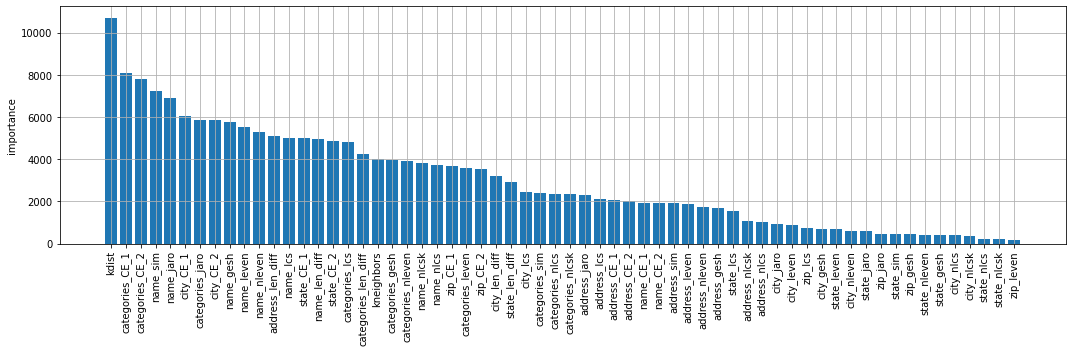

In [ ]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

#Check CV

In [ ]:
test_data = add_features(test_data, 1)
pred = inference_lgb(models, test_data[features])
test_data['pred'] = pred[:, 1]

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
def post_process(df):
    id2match = dict(zip(df['id'].values, df['matches'].str.split()))

    for base, match in df[['id', 'matches']].values:
        match = match.split()
        if len(match) == 1:        
            continue

        for m in match:
            if base not in id2match[m]:
                id2match[m].append(base)
    df['matches'] = df['id'].map(id2match).map(' '.join)
    return df 

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import optuna

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    test_pred_df = test_data[test_data['pred'] > x][['id', 'match_id']]
    out_df = pd.DataFrame()
    out_df['id'] = test_data['id'].unique().tolist()
    out_df['match_id'] = out_df['id']
    out_df = pd.concat([out_df, test_pred_df])
    out_df = out_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
    out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
    out_df = post_process(out_df)

    score = get_score(out_df)
    print(f"CV: {score:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-06-02 06:03:37,133] A new study created in memory with name: no-name-45d5cea1-ecc1-4d68-a2dc-1edbf4407410
[I 2022-06-02 06:04:10,111] Trial 0 finished with value: 0.8152812757822877 and parameters: {'threshold': 0.3342182360634859}. Best is trial 0 with value: 0.8152812757822877.


CV: 0.815281


[I 2022-06-02 06:04:29,134] Trial 1 finished with value: 0.8191031563202085 and parameters: {'threshold': 0.7173521443858546}. Best is trial 1 with value: 0.8191031563202085.


CV: 0.819103


[I 2022-06-02 06:04:49,728] Trial 2 finished with value: 0.8225407598731348 and parameters: {'threshold': 0.5441488063294943}. Best is trial 2 with value: 0.8225407598731348.


CV: 0.822541


[I 2022-06-02 06:05:08,443] Trial 3 finished with value: 0.7865020559758497 and parameters: {'threshold': 0.9338425724152384}. Best is trial 2 with value: 0.8225407598731348.


CV: 0.786502


[I 2022-06-02 06:05:28,548] Trial 4 finished with value: 0.8211339785374475 and parameters: {'threshold': 0.6662727518872449}. Best is trial 2 with value: 0.8225407598731348.


CV: 0.821134


[I 2022-06-02 06:05:50,752] Trial 5 finished with value: 0.7721996439106114 and parameters: {'threshold': 0.09952934660484902}. Best is trial 2 with value: 0.8225407598731348.


CV: 0.772200


[I 2022-06-02 06:06:10,161] Trial 6 finished with value: 0.8224466300109294 and parameters: {'threshold': 0.6004804343260618}. Best is trial 2 with value: 0.8225407598731348.


CV: 0.822447


[I 2022-06-02 06:06:33,008] Trial 7 finished with value: 0.7041687438255587 and parameters: {'threshold': 0.02919719810994814}. Best is trial 2 with value: 0.8225407598731348.


CV: 0.704169


[I 2022-06-02 06:06:52,896] Trial 8 finished with value: 0.8084818854622537 and parameters: {'threshold': 0.8426248031984428}. Best is trial 2 with value: 0.8225407598731348.


CV: 0.808482


[I 2022-06-02 06:07:12,313] Trial 9 finished with value: 0.8224760709081563 and parameters: {'threshold': 0.5659818623431673}. Best is trial 2 with value: 0.8225407598731348.


CV: 0.822476


[I 2022-06-02 06:07:32,980] Trial 10 finished with value: 0.8121946894814013 and parameters: {'threshold': 0.295408320175849}. Best is trial 2 with value: 0.8225407598731348.


CV: 0.812195


[I 2022-06-02 06:07:53,401] Trial 11 finished with value: 0.8208125255716363 and parameters: {'threshold': 0.4473578455797518}. Best is trial 2 with value: 0.8225407598731348.


CV: 0.820813
CV: 0.821949


[I 2022-06-02 06:08:20,257] Trial 12 finished with value: 0.8219492074634713 and parameters: {'threshold': 0.4942541695296972}. Best is trial 2 with value: 0.8225407598731348.
[I 2022-06-02 06:08:44,505] Trial 13 finished with value: 0.8149603087161187 and parameters: {'threshold': 0.3296476112431712}. Best is trial 2 with value: 0.8225407598731348.


CV: 0.814960


[I 2022-06-02 06:09:04,477] Trial 14 finished with value: 0.8157739220710143 and parameters: {'threshold': 0.772779897462282}. Best is trial 2 with value: 0.8225407598731348.


CV: 0.815774


[I 2022-06-02 06:09:24,706] Trial 15 finished with value: 0.8225114088769052 and parameters: {'threshold': 0.5705046948063711}. Best is trial 2 with value: 0.8225407598731348.


CV: 0.822511


[I 2022-06-02 06:09:48,399] Trial 16 finished with value: 0.8206797216780608 and parameters: {'threshold': 0.44190578011204523}. Best is trial 2 with value: 0.8225407598731348.


CV: 0.820680


[I 2022-06-02 06:10:08,585] Trial 17 finished with value: 0.8042402110673836 and parameters: {'threshold': 0.22320811027740511}. Best is trial 2 with value: 0.8225407598731348.


CV: 0.804240


[I 2022-06-02 06:10:28,978] Trial 18 finished with value: 0.8224445643499148 and parameters: {'threshold': 0.6050009914970061}. Best is trial 2 with value: 0.8225407598731348.


CV: 0.822445


[I 2022-06-02 06:10:47,330] Trial 19 finished with value: 0.7466948839406494 and parameters: {'threshold': 0.9831009184450168}. Best is trial 2 with value: 0.8225407598731348.


CV: 0.746695


[I 2022-06-02 06:11:07,807] Trial 20 finished with value: 0.815307351440155 and parameters: {'threshold': 0.7787684347147855}. Best is trial 2 with value: 0.8225407598731348.


CV: 0.815307


[I 2022-06-02 06:11:28,540] Trial 21 finished with value: 0.8224669222091697 and parameters: {'threshold': 0.5651152635297635}. Best is trial 2 with value: 0.8225407598731348.


CV: 0.822467


[I 2022-06-02 06:11:48,717] Trial 22 finished with value: 0.8224730941165399 and parameters: {'threshold': 0.5313010278642887}. Best is trial 2 with value: 0.8225407598731348.


CV: 0.822473


[I 2022-06-02 06:12:08,404] Trial 23 finished with value: 0.8189570662434803 and parameters: {'threshold': 0.39774921323663315}. Best is trial 2 with value: 0.8225407598731348.


CV: 0.818957


[I 2022-06-02 06:12:28,611] Trial 24 finished with value: 0.8210714682940413 and parameters: {'threshold': 0.6679833899291855}. Best is trial 2 with value: 0.8225407598731348.


CV: 0.821071


[I 2022-06-02 06:12:49,106] Trial 25 finished with value: 0.8222581247254601 and parameters: {'threshold': 0.5132794682617244}. Best is trial 2 with value: 0.8225407598731348.


CV: 0.822258


[I 2022-06-02 06:13:10,396] Trial 26 finished with value: 0.8006743309758787 and parameters: {'threshold': 0.20076449997254997}. Best is trial 2 with value: 0.8225407598731348.


CV: 0.800674


[I 2022-06-02 06:13:30,631] Trial 27 finished with value: 0.8217494225251962 and parameters: {'threshold': 0.6434582188962815}. Best is trial 2 with value: 0.8225407598731348.


CV: 0.821749


[I 2022-06-02 06:13:52,358] Trial 28 finished with value: 0.8183286716651993 and parameters: {'threshold': 0.3858166089596492}. Best is trial 2 with value: 0.8225407598731348.


CV: 0.818329


[I 2022-06-02 06:14:12,400] Trial 29 finished with value: 0.8168527357016891 and parameters: {'threshold': 0.7570531251620954}. Best is trial 2 with value: 0.8225407598731348.


CV: 0.816853


[I 2022-06-02 06:14:31,210] Trial 30 finished with value: 0.8085616304051951 and parameters: {'threshold': 0.8420942366106589}. Best is trial 2 with value: 0.8225407598731348.


CV: 0.808562


[I 2022-06-02 06:14:51,683] Trial 31 finished with value: 0.8225584272585384 and parameters: {'threshold': 0.5481695046550165}. Best is trial 31 with value: 0.8225584272585384.


CV: 0.822558


[I 2022-06-02 06:15:12,377] Trial 32 finished with value: 0.8224933880497854 and parameters: {'threshold': 0.5682758838731508}. Best is trial 31 with value: 0.8225584272585384.


CV: 0.822493


[I 2022-06-02 06:15:32,269] Trial 33 finished with value: 0.8211956513278563 and parameters: {'threshold': 0.462722214738377}. Best is trial 31 with value: 0.8225584272585384.


CV: 0.821196


[I 2022-06-02 06:15:52,645] Trial 34 finished with value: 0.8204686489554096 and parameters: {'threshold': 0.6852986206827825}. Best is trial 31 with value: 0.8225584272585384.


CV: 0.820469


[I 2022-06-02 06:16:13,765] Trial 35 finished with value: 0.8225156761777629 and parameters: {'threshold': 0.5809917645710988}. Best is trial 31 with value: 0.8225584272585384.


CV: 0.822516


[I 2022-06-02 06:16:34,718] Trial 36 finished with value: 0.8221657369105937 and parameters: {'threshold': 0.6238606062467725}. Best is trial 31 with value: 0.8225584272585384.


CV: 0.822166


[I 2022-06-02 06:16:54,435] Trial 37 finished with value: 0.8184009857078659 and parameters: {'threshold': 0.7305500864851064}. Best is trial 31 with value: 0.8225584272585384.


CV: 0.818401


[I 2022-06-02 06:17:15,452] Trial 38 finished with value: 0.8187406114373843 and parameters: {'threshold': 0.3930469015087779}. Best is trial 31 with value: 0.8225584272585384.


CV: 0.818741


[I 2022-06-02 06:17:34,714] Trial 39 finished with value: 0.8198903182315617 and parameters: {'threshold': 0.6994521280196192}. Best is trial 31 with value: 0.8225584272585384.


CV: 0.819890


[I 2022-06-02 06:17:54,530] Trial 40 finished with value: 0.8110263408691619 and parameters: {'threshold': 0.8219183721404353}. Best is trial 31 with value: 0.8225584272585384.


CV: 0.811026


[I 2022-06-02 06:18:14,985] Trial 41 finished with value: 0.8225026100985476 and parameters: {'threshold': 0.5576593025600967}. Best is trial 31 with value: 0.8225584272585384.


CV: 0.822503


[I 2022-06-02 06:18:34,871] Trial 42 finished with value: 0.8224761565026613 and parameters: {'threshold': 0.5295727515433815}. Best is trial 31 with value: 0.8225584272585384.


CV: 0.822476


[I 2022-06-02 06:19:00,700] Trial 43 finished with value: 0.8224959205759922 and parameters: {'threshold': 0.5908841111105799}. Best is trial 31 with value: 0.8225584272585384.


CV: 0.822496


[I 2022-06-02 06:19:21,756] Trial 44 finished with value: 0.8215025313414237 and parameters: {'threshold': 0.4746474354636711}. Best is trial 31 with value: 0.8225584272585384.


CV: 0.821503


[I 2022-06-02 06:19:41,055] Trial 45 finished with value: 0.8225315138890372 and parameters: {'threshold': 0.5431474850757355}. Best is trial 31 with value: 0.8225584272585384.


CV: 0.822532


[I 2022-06-02 06:20:01,353] Trial 46 finished with value: 0.8221135825647448 and parameters: {'threshold': 0.628016404342064}. Best is trial 31 with value: 0.8225584272585384.


CV: 0.822114


[I 2022-06-02 06:20:21,057] Trial 47 finished with value: 0.8202819432189097 and parameters: {'threshold': 0.4299238239664576}. Best is trial 31 with value: 0.8225584272585384.


CV: 0.820282


[I 2022-06-02 06:20:42,100] Trial 48 finished with value: 0.8161301450488508 and parameters: {'threshold': 0.34753009920637085}. Best is trial 31 with value: 0.8225584272585384.


CV: 0.816130


[I 2022-06-02 06:21:02,792] Trial 49 finished with value: 0.8220581288744521 and parameters: {'threshold': 0.5005946139326893}. Best is trial 31 with value: 0.8225584272585384.


CV: 0.822058


[I 2022-06-02 06:21:24,198] Trial 50 finished with value: 0.8123485854002616 and parameters: {'threshold': 0.2972221893029088}. Best is trial 31 with value: 0.8225584272585384.


CV: 0.812349


[I 2022-06-02 06:21:44,696] Trial 51 finished with value: 0.8224867922416388 and parameters: {'threshold': 0.5548093456948382}. Best is trial 31 with value: 0.8225584272585384.


CV: 0.822487


[I 2022-06-02 06:22:05,469] Trial 52 finished with value: 0.8224445794588217 and parameters: {'threshold': 0.6008987592879828}. Best is trial 31 with value: 0.8225584272585384.


CV: 0.822445


[I 2022-06-02 06:22:26,178] Trial 53 finished with value: 0.8224729303055293 and parameters: {'threshold': 0.5293521754698186}. Best is trial 31 with value: 0.8225584272585384.


CV: 0.822473


[I 2022-06-02 06:22:45,704] Trial 54 finished with value: 0.8211556432580334 and parameters: {'threshold': 0.6651230550061739}. Best is trial 31 with value: 0.8225584272585384.


CV: 0.821156


[I 2022-06-02 06:23:06,721] Trial 55 finished with value: 0.8215466214701973 and parameters: {'threshold': 0.4773600108419455}. Best is trial 31 with value: 0.8225584272585384.


CV: 0.821547


[I 2022-06-02 06:23:26,118] Trial 56 finished with value: 0.8224873716582921 and parameters: {'threshold': 0.5731543729755814}. Best is trial 31 with value: 0.8225584272585384.


CV: 0.822487


[I 2022-06-02 06:23:46,498] Trial 57 finished with value: 0.8201137659319787 and parameters: {'threshold': 0.4239166261690382}. Best is trial 31 with value: 0.8225584272585384.


CV: 0.820114


[I 2022-06-02 06:24:06,846] Trial 58 finished with value: 0.822527934040768 and parameters: {'threshold': 0.5440049248272031}. Best is trial 31 with value: 0.8225584272585384.


CV: 0.822528


[I 2022-06-02 06:24:27,130] Trial 59 finished with value: 0.8217528852213927 and parameters: {'threshold': 0.6436704128371413}. Best is trial 31 with value: 0.8225584272585384.


CV: 0.821753


[I 2022-06-02 06:24:46,317] Trial 60 finished with value: 0.8186457832070905 and parameters: {'threshold': 0.7251343618236081}. Best is trial 31 with value: 0.8225584272585384.


CV: 0.818646


[I 2022-06-02 06:25:07,101] Trial 61 finished with value: 0.8222209594071122 and parameters: {'threshold': 0.5075449786633734}. Best is trial 31 with value: 0.8225584272585384.


CV: 0.822221


[I 2022-06-02 06:25:26,754] Trial 62 finished with value: 0.8225018789326983 and parameters: {'threshold': 0.5389308515374027}. Best is trial 31 with value: 0.8225584272585384.


CV: 0.822502


[I 2022-06-02 06:25:46,781] Trial 63 finished with value: 0.8225159456842208 and parameters: {'threshold': 0.5955416270863418}. Best is trial 31 with value: 0.8225584272585384.


CV: 0.822516


[I 2022-06-02 06:26:07,334] Trial 64 finished with value: 0.8224575818393218 and parameters: {'threshold': 0.6012854027261101}. Best is trial 31 with value: 0.8225584272585384.


CV: 0.822458


[I 2022-06-02 06:26:27,697] Trial 65 finished with value: 0.821413561178064 and parameters: {'threshold': 0.6562222606098276}. Best is trial 31 with value: 0.8225584272585384.


CV: 0.821414


[I 2022-06-02 06:26:47,777] Trial 66 finished with value: 0.8218197362007092 and parameters: {'threshold': 0.48976830076632494}. Best is trial 31 with value: 0.8225584272585384.


CV: 0.821820


[I 2022-06-02 06:27:08,116] Trial 67 finished with value: 0.8222955089245454 and parameters: {'threshold': 0.614801093951951}. Best is trial 31 with value: 0.8225584272585384.


CV: 0.822296


[I 2022-06-02 06:27:28,021] Trial 68 finished with value: 0.8208920176109362 and parameters: {'threshold': 0.4505365382727354}. Best is trial 31 with value: 0.8225584272585384.


CV: 0.820892


[I 2022-06-02 06:27:52,433] Trial 69 finished with value: 0.6595715605304368 and parameters: {'threshold': 0.015671312755470068}. Best is trial 31 with value: 0.8225584272585384.


CV: 0.659572


[I 2022-06-02 06:28:12,750] Trial 70 finished with value: 0.8225135139575415 and parameters: {'threshold': 0.5686947191118497}. Best is trial 31 with value: 0.8225584272585384.


CV: 0.822514


[I 2022-06-02 06:28:33,288] Trial 71 finished with value: 0.8225233708357239 and parameters: {'threshold': 0.5854812718444661}. Best is trial 31 with value: 0.8225584272585384.


CV: 0.822523


[I 2022-06-02 06:28:52,695] Trial 72 finished with value: 0.8224792117889523 and parameters: {'threshold': 0.5756694682304906}. Best is trial 31 with value: 0.8225584272585384.


CV: 0.822479


[I 2022-06-02 06:29:13,007] Trial 73 finished with value: 0.8203601534422279 and parameters: {'threshold': 0.68869106405694}. Best is trial 31 with value: 0.8225584272585384.


CV: 0.820360


[I 2022-06-02 06:29:32,433] Trial 74 finished with value: 0.82247489210201 and parameters: {'threshold': 0.5296349671168107}. Best is trial 31 with value: 0.8225584272585384.


CV: 0.822475


[I 2022-06-02 06:29:53,496] Trial 75 finished with value: 0.8220170702977967 and parameters: {'threshold': 0.6326497061856716}. Best is trial 31 with value: 0.8225584272585384.


CV: 0.822017


[I 2022-06-02 06:30:15,334] Trial 76 finished with value: 0.7547081181518565 and parameters: {'threshold': 0.06930073207941773}. Best is trial 31 with value: 0.8225584272585384.


CV: 0.754708


[I 2022-06-02 06:30:35,868] Trial 77 finished with value: 0.8219961514322713 and parameters: {'threshold': 0.49591796911833064}. Best is trial 31 with value: 0.8225584272585384.


CV: 0.821996


[I 2022-06-02 06:30:55,490] Trial 78 finished with value: 0.8225615659753477 and parameters: {'threshold': 0.5874360026984531}. Best is trial 78 with value: 0.8225615659753477.


CV: 0.822562


[I 2022-06-02 06:31:15,833] Trial 79 finished with value: 0.8225180825572288 and parameters: {'threshold': 0.5904641253367416}. Best is trial 78 with value: 0.8225615659753477.


CV: 0.822518


[I 2022-06-02 06:31:35,197] Trial 80 finished with value: 0.8225215999155503 and parameters: {'threshold': 0.5412680487391436}. Best is trial 78 with value: 0.8225615659753477.


CV: 0.822522


[I 2022-06-02 06:31:55,511] Trial 81 finished with value: 0.8225443953085638 and parameters: {'threshold': 0.5443768584692109}. Best is trial 78 with value: 0.8225615659753477.


CV: 0.822544


[I 2022-06-02 06:32:15,975] Trial 82 finished with value: 0.8224740140425043 and parameters: {'threshold': 0.5313163031992285}. Best is trial 78 with value: 0.8225615659753477.


CV: 0.822474


[I 2022-06-02 06:32:36,616] Trial 83 finished with value: 0.8225417715730137 and parameters: {'threshold': 0.5444797174006791}. Best is trial 78 with value: 0.8225615659753477.


CV: 0.822542


[I 2022-06-02 06:32:56,255] Trial 84 finished with value: 0.8225706643190269 and parameters: {'threshold': 0.5474594545349614}. Best is trial 84 with value: 0.8225706643190269.


CV: 0.822571


[I 2022-06-02 06:33:17,098] Trial 85 finished with value: 0.8211755640957228 and parameters: {'threshold': 0.4621016001702297}. Best is trial 84 with value: 0.8225706643190269.


CV: 0.821176


[I 2022-06-02 06:33:36,596] Trial 86 finished with value: 0.8222267482987412 and parameters: {'threshold': 0.6194455443432619}. Best is trial 84 with value: 0.8225706643190269.


CV: 0.822227


[I 2022-06-02 06:33:58,705] Trial 87 finished with value: 0.819535273229078 and parameters: {'threshold': 0.4110512046169298}. Best is trial 84 with value: 0.8225706643190269.


CV: 0.819535


[I 2022-06-02 06:34:19,213] Trial 88 finished with value: 0.822264123650592 and parameters: {'threshold': 0.5131734212087393}. Best is trial 84 with value: 0.8225706643190269.


CV: 0.822264


[I 2022-06-02 06:34:40,209] Trial 89 finished with value: 0.8207437669122937 and parameters: {'threshold': 0.44571031588234217}. Best is trial 84 with value: 0.8225706643190269.


CV: 0.820744


[I 2022-06-02 06:35:00,337] Trial 90 finished with value: 0.8218638567287128 and parameters: {'threshold': 0.4912288504027148}. Best is trial 84 with value: 0.8225706643190269.


CV: 0.821864


[I 2022-06-02 06:35:21,025] Trial 91 finished with value: 0.8224716932945867 and parameters: {'threshold': 0.5401324220336791}. Best is trial 84 with value: 0.8225706643190269.


CV: 0.822472


[I 2022-06-02 06:35:40,784] Trial 92 finished with value: 0.8225307994525533 and parameters: {'threshold': 0.5513345004678454}. Best is trial 84 with value: 0.8225706643190269.


CV: 0.822531


[I 2022-06-02 06:36:00,987] Trial 93 finished with value: 0.8224858875301267 and parameters: {'threshold': 0.5542190868875897}. Best is trial 84 with value: 0.8225706643190269.


CV: 0.822486


[I 2022-06-02 06:36:21,553] Trial 94 finished with value: 0.8174724342167125 and parameters: {'threshold': 0.37031961369894756}. Best is trial 84 with value: 0.8225706643190269.


CV: 0.817472


[I 2022-06-02 06:36:42,214] Trial 95 finished with value: 0.8222493083165883 and parameters: {'threshold': 0.5163285367900509}. Best is trial 84 with value: 0.8225706643190269.


CV: 0.822249


[I 2022-06-02 06:37:01,971] Trial 96 finished with value: 0.8214163877462874 and parameters: {'threshold': 0.47039963242006083}. Best is trial 84 with value: 0.8225706643190269.


CV: 0.821416


[I 2022-06-02 06:37:22,315] Trial 97 finished with value: 0.8225305461967243 and parameters: {'threshold': 0.5509996232097025}. Best is trial 84 with value: 0.8225706643190269.


CV: 0.822531


[I 2022-06-02 06:37:41,983] Trial 98 finished with value: 0.8224928307147168 and parameters: {'threshold': 0.554381460469251}. Best is trial 84 with value: 0.8225706643190269.


CV: 0.822493


[I 2022-06-02 06:38:03,502] Trial 99 finished with value: 0.8224134179956086 and parameters: {'threshold': 0.607151886284198}. Best is trial 84 with value: 0.8225706643190269.


CV: 0.822413


In [ ]:
threshold = study.best_params['threshold']
threshold

0.5474594545349614

In [ ]:
study.best_value

0.8225706643190269

In [ ]:
test_pred_df = test_data[test_data['pred'] > threshold][['id', 'match_id']]
out_df = pd.DataFrame()
out_df['id'] = test_data['id'].unique().tolist()
out_df['match_id'] = out_df['id']
out_df = pd.concat([out_df, test_pred_df])
out_df = out_df.groupby('id')['match_id'].\
                    apply(list).reset_index()
out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
out_df = post_process(out_df)

score = get_score(out_df)
print(f"CV: {score:.6f}")

CV: 0.822571


# 間違っているものの中身を見る

In [ ]:
data = data.reset_index()

labelが1なのに0と予測しているもの

In [ ]:
false_negative = test_data.loc[(test_data["label"] == 1) & (test_data["pred"] <= threshold), :]
false_negative.describe()

,index,kdist,kneighbors,label,name_sim,name_gesh,name_leven,name_jaro,name_lcs,name_CE_1,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
count,1.250930e+05,125093.000000,125093.000000,125093.0,125093.000000,125093.000000,125093.000000,125093.000000,125093.000000,125093.000000,...,93933.000000,93933.000000,93933.000000,106736.000000,106817.000000,125093.000000,93933.000000,93933.000000,93933.000000,1.250930e+05
mean,5.707630e+05,0.001687,6.434597,1.0,0.254856,0.399383,16.825018,0.566084,8.413940,0.000027,...,12.570747,0.671684,8.949847,0.005043,0.005028,9.116074,0.542178,0.576740,0.577258,1.868718e-01
std,3.290560e+05,0.002551,5.271582,0.0,0.292304,0.246416,9.391501,0.226272,6.438838,0.000281,...,11.547633,0.241480,7.241352,0.006006,0.005991,10.988923,0.350633,0.328433,0.327954,1.694933e-01
min,1.800000e+01,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000002,...,0.000000,0.000000,0.000000,0.000002,0.000002,0.000000,0.000000,0.000000,0.000000,2.467196e-09
25%,2.858000e+05,0.000319,2.000000,1.0,0.000000,0.200000,10.000000,0.444444,4.000000,0.000002,...,0.000000,0.482284,4.000000,0.000725,0.000717,0.000000,0.000000,0.285714,0.285714,3.043104e-02
50%,5.685750e+05,0.000781,5.000000,1.0,0.151317,0.380952,16.000000,0.558199,7.000000,0.000002,...,12.000000,0.579365,7.000000,0.002578,0.002578,6.000000,0.714286,0.466667,0.466667,1.372108e-01
75%,8.567440e+05,0.001939,10.000000,1.0,0.479102,0.575342,22.000000,0.693362,12.000000,0.000002,...,17.000000,1.000000,12.000000,0.006273,0.006273,13.000000,0.823529,1.000000,1.000000,3.242802e-01
max,1.138810e+06,0.037239,19.000000,1.0,1.000000,1.000000,59.000000,1.000000,53.000000,0.004961,...,87.000000,1.000000,77.000000,0.022032,0.022032,90.000000,1.000000,1.000000,1.000000,5.474473e-01


In [ ]:
false_negative.sample(min(false_negative.shape[0], 30))

,index,id,match_id,kdist,kneighbors,label,name_sim,name_gesh,name_leven,name_jaro,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
1063133,987298,E_ddcc338635a65a,E_d5aa11b5a02a87,0.000208,1,1,0.307471,0.285714,13.0,0.472904,...,27.0,0.669952,28.0,0.000004,0.000005,11,0.509434,0.528302,0.666667,0.406614
2245361,1074114,E_f161efc8ef1c9a,E_8bae85bb6b5371,0.000493,3,1,0.125389,0.509091,19.0,0.556508,...,0.0,1.000000,19.0,0.004645,0.004645,0,0.000000,1.000000,1.000000,0.070503
699052,258959,E_3a23c6d5b9bad6,E_6ae05c71f8fe25,0.000398,1,1,0.857578,0.827586,10.0,0.932843,...,18.0,0.566783,9.0,0.000695,0.000002,6,0.692308,0.450000,0.346154,0.173218
2795290,1035103,E_e89209afcff153,E_2c022c3c8aa80c,0.002391,4,1,0.000000,0.375000,9.0,0.444444,...,21.0,0.505556,7.0,0.000014,0.003305,4,0.875000,0.350000,0.291667,0.002366
851427,563637,E_7eaad89889ca68,E_c814a16ab21629,0.000854,1,1,0.538399,0.666667,6.0,0.870000,...,0.0,1.000000,9.0,0.005683,0.005683,0,0.000000,1.000000,1.000000,0.209029
5055531,1000442,E_e0b9ffdf142dcf,E_df1e3267d2a692,0.000881,8,1,0.495564,0.438356,28.0,0.638454,...,44.0,0.581818,11.0,0.000004,0.008152,44,0.800000,1.000000,0.200000,0.461828
3650892,468256,E_6939c55618ff39,E_cd5765facb51cc,0.007603,6,1,0.000000,0.222222,21.0,0.348810,...,NaN,NaN,NaN,0.001094,NaN,9,NaN,NaN,NaN,0.009752
4500938,1029939,E_e765a536ae77e4,E_6c87609c5e2a72,0.000174,7,1,0.000000,0.045455,28.0,0.367050,...,0.0,1.000000,9.0,0.008548,0.008548,0,0.000000,1.000000,1.000000,0.132561
949774,760017,E_aabbca4c5f7811,E_62432eff78095c,0.000120,1,1,0.000000,0.333333,6.0,0.561905,...,0.0,1.000000,10.0,0.002273,0.002273,0,0.000000,1.000000,1.000000,0.394400
9996930,633399,E_8e68ee2a7b3ecf,E_a3a3a4bf5f1d11,0.000787,17,1,0.000000,0.117647,18.0,0.343651,...,0.0,1.000000,9.0,0.008548,0.008548,0,0.000000,1.000000,1.000000,0.075580


In [ ]:
for id, match_id in false_negative.sample(min(false_negative.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
377394,E_54c9f52a3f2399,Carsi Apart Evler,40.258048,40.225602,NaN,NaN,NaN,NaN,TR,NaN,NaN,Residential Buildings (Apartments / Condos),P_262c401fe4068e,1,1.0
959036,E_d76e7874ee3100,Merkez Apart Evler,40.259422,40.228405,Velişaban mahallesi,Bayburt,NaN,NaN,TR,NaN,NaN,Residential Buildings (Apartments / Condos),P_262c401fe4068e,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
523413,E_759e95c65eea19,Piazza LCW,41.276128,36.354772,NaN,NaN,NaN,NaN,TR,NaN,NaN,Department Stores,P_fd119c2131d34c,4,1.0
579259,E_8236554c87fd99,Piazza alış veriş merkezi,41.276972,36.354357,NaN,NaN,NaN,NaN,TR,NaN,NaN,Shopping Malls,P_fd119c2131d34c,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
459693,E_674af1192882bd,Некрасовский педколледж № 1 (Корпус № 2),59.859898,30.29839,"Кубинская ул., 32, лит. А",Санкт-Петербург,NaN,196247,RU,http://www.nekrasovspb.ru,+78122412821,General Colleges & Universities,P_1921d17e04d5cb,2,1.0
743749,E_a71653bbbd5212,Кабинета пения),59.860252,30.29834,NaN,NaN,NaN,NaN,RU,NaN,NaN,NaN,P_1921d17e04d5cb,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
527861,E_769d74d4535938,Kroger,33.859708,-83.95464,910 Athens Hwy,Loganville,GA,30052,US,https://www.kroger.com,7705541100,"Supermarkets, Grocery Stores",P_e3d3c00cf37f74,1,1.0
996384,E_dfd6734a7893f8,Kroger Fuel Center,33.859135,-83.95412,910 Athens Hwy,Loganville,GA,30052,US,NaN,NaN,Gas Stations,P_e3d3c00cf37f74,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
646623,E_9154df9167fe25,История 46,55.438326,65.316533,NaN,NaN,NaN,NaN,RU,NaN,NaN,NaN,P_895126060a4ae6,4,1.0
940216,E_d32e5c056bf7a6,28 Кабинет,55.438282,65.316737,NaN,NaN,NaN,NaN,RU,NaN,NaN,Auditoriums,P_895126060a4ae6,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
123720,E_1bbcc2ffc433d6,XI IA 4 SMAN 3 Surakarta,-7.564510,110.840498,Kerkoff,Surakarta,Central Java,NaN,ID,NaN,NaN,College Classrooms,P_48dc1c024bb08e,4,1.0
475248,E_6ad078ab15792c,X-10 SMA Negeri 3 Surakarta,-7.565609,110.838275,Jl. Prof. W.Z Johannes 58,Surakarta,Indonesia,NaN,ID,NaN,NaN,College Classrooms,P_48dc1c024bb08e,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
274438,E_3d9ea22f0a7d50,Quantum Bistro Cinere Mall,-6.325601,106.779871,Cinere Raya,Serpong,Banten,NaN,ID,NaN,NaN,NaN,P_f22dd90a81aeea,4,1.0
1008345,E_e27dc28ff85b3b,Quantum bistro restaurant,-6.324416,106.784320,"Mal cinere, jl.cinere raya",Depok,Jawa Barat,NaN,ID,NaN,NaN,Cafés,P_f22dd90a81aeea,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
210363,E_2f396d76ac4271,Ferry Landing - Galveston,29.327344,-94.773449,NaN,Galveston,TX,NaN,US,NaN,NaN,Piers,P_3f8941468849c5,1,1.0
825484,E_b9606c7be24c90,Galveston - Bolivar Ferry,29.326516,-94.773903,1000 Ferry Rd,Galveston,TX,77550,US,http://www.galveston.com/galvestonferry,4097952230,"Boats or Ferries, Harbors / Marinas",P_3f8941468849c5,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
472646,E_6a39fa9dc2cfc8,Yeniçiftlik Plajı,40.999782,27.818701,NaN,NaN,NaN,NaN,TR,NaN,NaN,Beaches,P_5f21dca42c2f3b,4,1.0
872371,E_c3f3a143b3c1bf,Yeniçiftlik Sahil,40.992413,27.842278,Yeniciftlik Sahil,Tekirdag,NaN,NaN,TR,NaN,NaN,Cafés,P_5f21dca42c2f3b,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
125143,E_1c0bff12e7635f,Akron Children's Hospital,41.079448,-81.525121,1 Perkins Sq,Akron,OH,44308,US,http://akronchildrens-jobs.com,8002620333,Medical Centers,P_53964a742bfcd9,4,1.0
364110,E_51d093a3d6c26c,Maternal Fetal Medicine,41.078521,-81.524416,224 W Exchange St,Akron,OH,44302,US,NaN,+13303841650,NaN,P_53964a742bfcd9,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
692057,E_9b714c96e7930f,Molino Cafe,40.978789,27.530617,Sahil,Tekirdağ,Türkiye,NaN,TR,NaN,2822632454,"Cafés, Hookah Bars",P_95cf0c902c24e1,1,1.0
737391,E_a5a6f7999c74f8,molino arkası manzara,40.982061,27.537216,NaN,NaN,NaN,NaN,TR,NaN,NaN,Beer Gardens,P_95cf0c902c24e1,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
120226,E_1af7036af13822,Ülkü Alan Pasajı,39.922412,32.853149,Izmir Caddesi,NaN,NaN,NaN,TR,NaN,NaN,"Sporting Goods Shops, Shoe Stores",P_f57762f15c8b08,1,1.0
518033,E_7470d11c870c9a,Ülkealan Pasajı,39.922608,32.852752,İzmir Cad. Kızılay,Ankara,Türkiye,NaN,TR,NaN,NaN,Sporting Goods Shops,P_f57762f15c8b08,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
628079,E_8d3a79ed67af53,PT. PJB UP Muara Karang,-6.112521,106.784197,Jl. Pluit Utara Raya No. 2A,NaN,NaN,NaN,ID,NaN,NaN,Offices,P_6016ac547f58b8,2,1.0
740483,E_a659dc6e3e8f6f,Unit Pembangkitan Muara Karang,-6.110377,106.783090,NaN,NaN,NaN,NaN,ID,NaN,NaN,Power Plants,P_6016ac547f58b8,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
414727,E_5d2e5e66fb943a,у гитлера,56.141786,47.172745,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Cafeterias,P_5271fd5f8c141e,4,1.0
1041182,E_e9f14215d12c3b,Альбинка,56.142726,47.173267,NaN,NaN,NaN,NaN,RU,NaN,NaN,Hookah Bars,P_5271fd5f8c141e,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
382704,E_55fbc3154aa2d5,Nicholson's Pubs,53.401812,-2.970577,36 Hope Street,Liverpool,NaN,L1 9BX,GB,NaN,NaN,NaN,P_5178faf2ee3db4,3,1.0
861195,E_c16e5d13012427,Philarmonic,53.403773,-2.971957,Hope St.,Liverpool,NaN,NaN,GB,NaN,NaN,NaN,P_5178faf2ee3db4,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
213346,E_2fe661d6b8350d,Бауманка,55.766615,37.684527,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Engineering Buildings,P_45027185ad27fc,4,1.0
793739,E_b2456e28d2c49c,Крыша ГЗ МГТУ им. Н.Э. Баумана,55.765534,37.684050,NaN,NaN,NaN,NaN,RU,NaN,NaN,Buildings,P_45027185ad27fc,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
707820,E_9efbea6e13e055,Soma Üst Devlet Hastahanesi ÇocukYataklı Tedav...,39.178367,27.615931,NaN,NaN,NaN,NaN,TR,NaN,NaN,Hospitals,P_b34ba8ba1448b0,4,1.0
871824,E_c3d441168f2ea4,Soma Sanayi Devlet Hastanesi,39.178426,27.615650,NaN,NaN,NaN,NaN,TR,NaN,NaN,Hospitals,P_b34ba8ba1448b0,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
459263,E_673380f55e194d,İzmit Fuar Lunapark,40.760009,29.937963,NaN,NaN,NaN,NaN,TR,NaN,NaN,NaN,P_355a0b646d8450,4,1.0
653477,E_92d943ee64928a,Kocaeli Fuari,40.762330,29.935473,Kocaeli,NaN,NaN,NaN,TR,NaN,NaN,Conferences,P_355a0b646d8450,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
267902,E_3c2a4f6fa15135,11 IPA 4 ST.Thomas 1,3.588656,98.668275,Jl S.Parman no.109 Medan,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_f3e552b97439d3,4,1.0
928195,E_d07dd7daabce31,XII-IPA 1,3.589640,98.668840,SMA St. Thomas 1,Medan,NaN,NaN,ID,NaN,NaN,"Student Centers, College Classrooms",P_f3e552b97439d3,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
68424,E_0f4ec89a130baf,Pizza Three,1.308102,103.915201,NaN,Singapore,NaN,NaN,SG,NaN,NaN,Pizza Places,P_6661d7abab76a4,2,1.0
928103,E_d07723a2d3c58c,Pizza Five,1.308351,103.914949,NaN,Singapore,NaN,NaN,SG,NaN,NaN,Pizza Places,P_6661d7abab76a4,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
279466,E_3ebc18ce89763c,Дыбенко 22/1 мама и папа),55.869812,37.485210,NaN,NaN,NaN,NaN,RU,NaN,NaN,Residential Buildings (Apartments / Condos),P_8599212c52d80a,1,1.0
880447,E_c5c13a1f12c7b0,"ул. Дыбенко, 22, корп. 1",55.872553,37.483849,"ул. Дыбенко, 22, корп..1",Москва,Москва,NaN,RU,NaN,NaN,Residential Buildings (Apartments / Condos),P_8599212c52d80a,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
503774,E_7147a190dfceaf,Kalnakrogs,56.823990,24.245218,NaN,Odukalns,NaN,LV-2123,LV,NaN,NaN,Bistros,P_d5f794cb12a89e,2,1.0
808159,E_b57dab4c762b35,"""SIA Garozu ķēķis kaf.\""Kalnakrogs\""""",56.824487,24.244256,Rīgas iela103 ķekava,NaN,NaN,NaN,LV,NaN,NaN,NaN,P_d5f794cb12a89e,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
626489,E_8cdf06762805d8,Tam Koprunun Ortasi,41.037912,29.042472,NaN,NaN,NaN,NaN,TR,NaN,NaN,"Bridges, General Entertainment, Aquariums",P_fbe61733fcdebe,4,1.0
949830,E_d55cd44d7559c5,Boğaziçi Köprüsü Arkadaşımın Dayısı,41.039171,29.041018,İstanbul,NaN,NaN,NaN,TR,NaN,NaN,Community Centers,P_fbe61733fcdebe,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
849752,E_bed5e2a32732a5,Ulucanlar Cezaevi Müzesi Sineması,39.933887,32.871888,NaN,NaN,NaN,NaN,TR,NaN,NaN,Indie Movie Theaters,P_0b0f7614bd02fd,3,1.0
1120350,E_fbde67762f0364,Ulucanlar Ceza Evi Müzesi ANKARA,39.936594,32.876106,NaN,NaN,NaN,NaN,TR,NaN,NaN,History Museums,P_0b0f7614bd02fd,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
36091,E_0818c904d0b693,The Day Spa & Salon at Barton Creek,30.258439,-97.808173,2901 S Capital of Texas Hwy,Austin,TX,78746,US,http://spaatbartoncreekmall.com,5123273316,Nail Salons,P_8dbbb1b7f9d674,1,1.0
699544,E_9d1dca4579eda4,Spa at Barton Creek Mall,30.260320,-97.806976,2901 S Capital of Texas Hwy,Austin,TX,78746,US,NaN,NaN,Spas,P_8dbbb1b7f9d674,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
10742,E_0270f4e610df6b,AAFES XCHANGE,18.419544,-66.124037,NaN,Fort Buchanan,NaN,NaN,PR,NaN,NaN,"Shops & Services, Department Stores",P_3bc6c6f662712a,1,1.0
1060051,E_ee39a1dedd5b55,Army & Air Force Exchange Service (AAFES) PX,18.419831,-66.124281,"Bld. 689, S. Terminal Rd.",Fort Buchanan,PR,NaN,PR,NaN,7877928919,"Shopping Malls, Military Bases",P_3bc6c6f662712a,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
211634,E_2f82dbd9c88ba4,psychopharmocology,37.955650,-122.055171,NaN,Pleasant Hill,Calif,NaN,US,NaN,NaN,NaN,P_609f78786092f5,4,1.0
1015940,E_e43c0819ed0904,S304,37.956511,-122.054935,NaN,Pleasant Hill,Calif,NaN,US,NaN,NaN,NaN,P_609f78786092f5,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
619163,E_8b371f632f9ad6,Room 1227,1.374574,103.751998,NaN,NaN,NaN,658072,SG,NaN,NaN,General Colleges & Universities,P_70493458f51142,4,1.0
980986,E_dc5fab6f00e29d,"Room, 1601 Cck",1.374599,103.751915,NaN,NaN,NaN,NaN,SG,NaN,NaN,NaN,P_70493458f51142,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
263780,E_3b3bdf1e4e321c,Выставка Инноваций на Селигере,57.248587,33.079037,NaN,NaN,NaN,NaN,RU,NaN,NaN,NaN,P_e6eaeae67f4b4b,4,1.0
486748,E_6d64afed3e8130,Офис БД-Селигер :),57.248642,33.078771,NaN,NaN,NaN,NaN,RU,NaN,NaN,Buildings,P_e6eaeae67f4b4b,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
112209,E_192586f1653ddc,caixa economica federal ag sta catarina,-23.650677,-46.660493,NaN,NaN,NaN,NaN,BR,NaN,NaN,Banks,P_6502de5bb7377f,1,1.0
268619,E_3c5356cdf5afbd,Caixa Econômica Federal,-23.651502,-46.669334,"Av. Vereador João de Luca, 820",São Paulo,São Paulo,04381-000,BR,http://www.caixa.gov.br,551132998450,Banks,P_6502de5bb7377f,1,1.0


labelが0なのに1と予測しているもの

In [ ]:
false_positive = test_data.loc[(test_data["label"] == 0) & (test_data["pred"] > threshold), :]
false_positive.describe()

,index,kdist,kneighbors,label,name_sim,name_gesh,name_leven,name_jaro,name_lcs,name_CE_1,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
count,4.627800e+04,46278.000000,46278.000000,46278.0,46278.000000,46252.000000,46252.000000,46252.000000,46252.000000,46260.000000,...,37917.000000,37917.000000,37917.000000,41417.000000,41411.000000,46278.000000,37917.000000,37917.000000,37917.000000,46278.000000
mean,5.676362e+05,0.001486,4.473659,0.0,0.508475,0.597761,12.454964,0.725446,11.732682,0.000057,...,10.127700,0.784807,11.537279,0.004536,0.004577,8.818791,0.374059,0.739715,0.737399,0.771582
std,3.286136e+05,0.002463,4.722988,0.0,0.337920,0.257214,9.479696,0.227664,7.366804,0.000398,...,12.324349,0.239506,7.868551,0.005527,0.005572,11.821621,0.362875,0.321864,0.323728,0.137737
min,1.000000e+01,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000002,...,0.000000,0.000000,0.000000,0.000002,0.000002,0.000000,0.000000,0.000000,0.000000,0.547464
25%,2.795810e+05,0.000208,1.000000,0.0,0.235761,0.428571,5.000000,0.583333,6.000000,0.000002,...,0.000000,0.542593,6.000000,0.000465,0.000472,0.000000,0.000000,0.421053,0.416667,0.647843
50%,5.669930e+05,0.000549,2.000000,0.0,0.550238,0.619718,11.000000,0.779266,11.000000,0.000002,...,7.000000,0.888000,11.000000,0.002374,0.002374,4.000000,0.411765,1.000000,1.000000,0.766387
75%,8.529850e+05,0.001602,6.000000,0.0,0.777844,0.794521,18.000000,0.905042,16.000000,0.000002,...,17.000000,1.000000,15.000000,0.006027,0.006273,14.000000,0.750000,1.000000,1.000000,0.895866
max,1.138792e+06,0.038398,19.000000,0.0,1.000000,1.000000,58.000000,1.000000,55.000000,0.004961,...,82.000000,1.000000,93.000000,0.022032,0.022032,98.000000,1.000000,1.000000,1.000000,0.999998


In [ ]:
false_positive.sample(min(false_positive.shape[0], 30))

,index,id,match_id,kdist,kneighbors,label,name_sim,name_gesh,name_leven,name_jaro,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
589381,39962,E_08f5c00de83e35,E_4f87bc988fa1fb,0.000100,1,0,1.000000,0.962963,1.0,0.985185,...,5.0,0.776190,10.0,0.004259,0.004320,0,0.357143,0.714286,0.714286,0.840101
7087525,508904,E_7267c8dce738b6,E_b618f69926ed78,0.000224,12,0,0.442439,0.690909,13.0,0.648718,...,0.0,1.000000,11.0,0.001679,0.001679,0,0.000000,1.000000,1.000000,0.751213
10141337,922607,E_cf4058f7b72670,E_f0806e676b9bc6,0.000041,17,0,0.000000,0.190476,12.0,0.436508,...,12.0,0.460101,3.0,0.000172,0.000421,4,0.800000,0.272727,0.200000,0.665649
5954637,520581,E_75003a1a8b1df3,E_497153724274af,0.003838,10,0,0.296424,0.375000,29.0,0.564133,...,0.0,1.000000,17.0,0.001544,0.001544,0,0.000000,1.000000,1.000000,0.651184
3602607,371790,E_538b2edcdca6e5,E_321697c80f9617,0.003596,6,0,0.890055,0.972973,1.0,0.989474,...,NaN,NaN,NaN,NaN,0.005936,17,NaN,NaN,NaN,0.909256
1004779,870353,E_c382f8ca53def0,E_b4df80eb8775e6,0.000351,1,0,0.877653,0.722222,10.0,0.913043,...,38.0,0.527056,7.0,0.000002,0.000969,30,0.863636,0.500000,0.159091,0.837551
1438574,598652,E_868c5a90f7b18e,E_2165adcb4ffd18,0.000363,2,0,0.000000,0.333333,17.0,0.550758,...,0.0,1.000000,18.0,0.011670,0.011670,0,0.000000,1.000000,1.000000,0.590445
8178948,414320,E_5d1614b4bf0a7d,E_b5d9f50a1f1c0c,0.000710,14,0,0.642824,0.566038,15.0,0.847143,...,NaN,NaN,NaN,NaN,0.005065,14,NaN,NaN,NaN,0.769542
9593214,965385,E_d8dcc46c2bf6cb,E_5756fa7cad8c3e,0.002818,16,0,0.312534,0.857143,2.0,0.943636,...,34.0,0.686869,10.0,0.002160,0.000007,32,0.772727,0.227273,0.833333,0.718424
577456,16006,E_039d93c447e587,E_98655f391ca00b,0.000201,1,0,0.000000,0.235294,9.0,0.490741,...,0.0,1.000000,10.0,0.006869,0.006869,0,0.000000,1.000000,1.000000,0.982621


In [ ]:
for id, match_id in false_positive.sample(min(false_positive.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
824276,E_b9183599d62c64,Can Emlak,37.764707,30.552542,Piri Mehmet Mahallesi,Isparta,MERKEZ,32100,TR,NaN,NaN,Real Estate Offices,P_ac2708d7aff117,0,1.0
908047,E_cbfcd8ae1d1fae,Emlak Emlak,37.765785,30.551363,Piri mehmet Mahallesi,Isparta,NaN,NaN,TR,NaN,NaN,Real Estate Offices,P_ef7d3b747255b9,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
634431,E_8ea4d7d9539a76,Çınar Kıraathanesi,40.978190,27.490484,NaN,tekirdağ,NaN,59000,TR,NaN,NaN,Turkish Coffeehouses,P_3031cee0065118,1,1.0
766043,E_ac11c66fb223f6,Çınar Kıraathanesi,40.975478,27.497511,NaN,NaN,NaN,NaN,TR,NaN,NaN,Cafés,P_5f2c32d3d8500f,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
13149,E_02f915ebd216b3,Vonal Kır Bahçesi,40.686439,29.558569,NaN,NaN,NaN,NaN,TR,NaN,NaN,Other Nightlife,P_f5b196a872354b,0,1.0
127214,E_1c8330931c2e43,Şato Kır Bahçesi,40.686419,29.558694,NaN,NaN,NaN,NaN,TR,NaN,NaN,Other Nightlife,P_51b41160a4bf73,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
539796,E_794d764e0bb776,大岡五丁目第二公園,35.412931,139.600943,南区大岡5-40,横浜市,神奈川県,232-0061,JP,NaN,NaN,Parks,P_f2bdab36fb2eda,0,1.0
670935,E_96b5ad2d693b3b,大岡五丁目公園,35.412938,139.600355,NaN,NaN,NaN,NaN,JP,NaN,NaN,Parks,P_caa33c23ecb007,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
374922,E_543ca51de95254,Clothes,35.272217,-80.669268,NaN,Charlotte,NC,NaN,US,NaN,NaN,Clothing Stores,P_ddfad104812aa6,4,1.0
1029116,E_e73570597e91f8,Clothes PSC34,35.272369,-80.669321,NaN,Charlotte,NC,NaN,US,NaN,NaN,Clothing Stores,P_4c5da033c20162,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
556288,E_7d04fc71fcb8e2,Departure Hall Hang Nadim International Airpor...,1.125643,104.117805,Hang Nadim International Airport (BTH),Batam,Riau Islands,29000,ID,NaN,NaN,Airport Terminals,P_c0721892ef954b,4,1.0
885564,E_c6e6a6eb4a0d60,Cargo Terminal,1.125726,104.117732,Hang Nadim International Airport (BTH),Batam,Kepulauan Riau,29466,ID,NaN,NaN,"Airport Terminals, Parking, Offices",P_35c78159acac11,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
717515,E_a12c401bca2b17,Mugg & Bean,-34.035347,23.044634,Kenyans mall,Knysna,NaN,6571,ZA,http://www.muggandbean.co.za,NaN,Cafés,P_7167c159e40770,0,1.0
905807,E_cb7a4de8b25212,Mugg & Bean,-34.035369,23.044680,Knysna Mall,Knysna,Western Cape,NaN,ZA,NaN,NaN,Cafés,P_ff3822d09be759,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
481527,E_6c36f74caff098,M.2/3 Chitralada,13.765979,100.522382,NaN,Bangkok,NaN,NaN,TH,NaN,NaN,College Classrooms,P_a1cf2d43913943,0,1.0
693666,E_9bce56a7f486c1,M.4/2 Chitralada School,13.766118,100.522733,NaN,NaN,NaN,NaN,TH,NaN,NaN,College Classrooms,P_7f8a4c4bf12f9d,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
429742,E_6094d9c58466d4,Necip Fazıl Şehir Hastanesi Hemodiyaliz Servisi,37.502380,37.005200,Necip Fazıl şehir hastanesi,Kahramanmaraş,NaN,NaN,TR,NaN,NaN,Hospitals,P_49b67ac2e4c546,0,1.0
490984,E_6e6036e54a8e0f,necip fazıl şehir hastanesi göğüs hastalıkları...,37.502742,37.004622,NaN,NaN,NaN,NaN,TR,NaN,NaN,Housing Developments,P_d2216217ec844e,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
546494,E_7acfb7c717dbdb,Pendik sahil,40.877165,29.222160,NaN,NaN,NaN,NaN,TR,NaN,NaN,Other Great Outdoors,P_77a9cd705a118f,4,1.0
838828,E_bc5eb1eb77c192,Pendik Sahil Balkon,40.873308,29.226758,Pendik Burnu Sahil,NaN,NaN,NaN,TR,NaN,NaN,NaN,P_f528b3a6feac62,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
622835,E_8c07d302114595,Simpson College Pool,41.365497,-93.565945,"701 N C St, Indianola, IA 50125",Indianola,IA,50125,US,NaN,NaN,College Gyms,P_8b15408b1e6060,0,1.0
655137,E_9339f5ad2a461d,Simpson College Security Office,41.359814,-93.561019,701 N C St,Indianola,IA,50125,US,NaN,5159611711,NaN,P_51fe4c724891c7,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
374380,E_541d168bcef673,Grand Haven Bridge,43.074065,-86.218557,US 31,Grand Haven,MI,NaN,US,NaN,NaN,Bridges,P_2548312fc2db2f,0,1.0
415911,E_5d707d8d6fbcb3,Grand Haven Jewelry,43.065281,-86.221446,NaN,NaN,NaN,NaN,US,NaN,NaN,NaN,P_c1f2ebe6a0d449,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
275955,E_3df0dec45d2c9e,洗濯船,35.694038,139.704439,歌舞伎町1-1-8,新宿区,東京都,160-0021,JP,http://www.geocities.jp/g_sentaku/,0332089716,Bars,P_ed3998de62a63f,0,1.0
479118,E_6bad897fcfff6c,ゴールデンダスト,35.693975,139.704368,歌舞伎町1-1-8,Shinjuku,Tōkyō,160-0021,JP,http://miyashitakikaku.com/store/goldendust/,332053436,Bars,P_dde6b21bd1206f,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
259350,E_3a3ad086668429,Gedung F FKIP UNS,-7.557289,110.855883,Universitas Sebelas Maret (UNS),Surakarta,Jawa Tengah,NaN,ID,NaN,NaN,College Communications Buildings,P_d8c9d6c2e85541,0,1.0
613952,E_8a05d0863091d1,Ruang Sidang Gedung Ungu FKIP UNS,-7.557032,110.855918,Jl. Ir. Sutami,Surakarta,Jawa Tengah,NaN,ID,NaN,NaN,College Communications Buildings,P_dd60a0cbbafa21,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
738144,E_a5d40c6bf13778,Mersin TV,36.803389,34.622899,NaN,NaN,NaN,NaN,TR,NaN,NaN,TV Stations,P_91a541e1f0bfc1,1,1.0
981634,E_dc84ebfaff2e0e,Mersin Adalet Sarayı,36.803469,34.621656,Zeytinlibahçe Cad.,Mersin,Mersin,33050,TR,http://www.mersin.adalet.gov.tr,3242321845,Courthouses,P_3b8d2ba7c43d43,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
561377,E_7e28c5ac0e01f4,Ugg Australia 酒々井プレミアムアウトレット店,35.713681,140.293550,飯積2-4-1,印旛郡酒々井町,千葉県,285-0912,JP,http://www.uggaustralia.jp,+81433088990,"Shoe Stores, Outlet Stores",P_1fbacfc7046d78,1,1.0
970587,E_da03cad2273aa9,酒々井プレミアム・アウトレット,35.713562,140.294014,飯積2-4-1,酒々井町,千葉県,285-0912,JP,https://www.premiumoutlets.co.jp/shisui/,434816160,Outlet Malls,P_e27835e5cc94f8,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
246199,E_373eba74f9d092,Copec,-33.466921,-70.62314,San Eugenio 1602,Santiago,Metropolitana,NaN,CL,NaN,NaN,"Gas Stations, Professional & Other Places",P_db18573f4cddd5,0,1.0
887360,E_c75166de0a1845,Punto Copec,-33.466789,-70.62310,San Eugenio 1602,Provincia de Santiago,Región Metropolitana,NaN,CL,NaN,NaN,Convenience Stores,P_ca3df9d8d20edd,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
318818,E_47a65cd1fc77b5,35 Kallang Pudding Rd,1.329088,103.877789,NaN,NaN,NaN,NaN,SG,NaN,NaN,NaN,P_ae1b079030eee9,0,1.0
450201,E_65288016e4d991,37 Kallang Pudding Rd Tong Lee Building,1.329391,103.879004,NaN,NaN,NaN,NaN,SG,NaN,NaN,Offices,P_d97ac8d3f65df0,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
307579,E_4516b68916f799,"Upper East Dental Innovations: Sharde Harvey, DDS",40.763323,-73.968286,121 E 60th St Apt 1B,New York,NY,10022,US,http://www.uppereastdentalinnovations.com,+12126971701,Dentist's Offices,P_ebde413753ed55,1,1.0
758156,E_aa517611e26f52,Upper East Side Dental Innovations,40.763257,-73.968296,121 E 60th St Apt 1B,New York,NY,10022,US,https://www.uppereastdentalinnovations.com,+12126971701,Dentist's Offices,P_28d416ff67351e,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
69291,E_0f82068a4a62d0,Это что за остановка? Бологое иль Попрвка?,56.834954,35.893476,NaN,NaN,NaN,NaN,RU,NaN,NaN,Train Stations,P_181eed2424fb08,2,1.0
181272,E_28a9fb5718931d,Тверь,56.835189,35.893692,NaN,NaN,NaN,NaN,RU,NaN,NaN,Train Stations,P_e72cfa3eead272,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
825699,E_b96b58cc867009,Kaiser Permanente Medical Center,37.783395,-122.440600,2238 Geary Blvd,San Francisco,CA,94115,US,http://kp.org,NaN,Medical Centers,P_886cdb29a65d75,1,1.0
995007,E_df87b98dcffe15,Kaiser Permanente Surgery 2NE,37.783052,-122.439212,2238 Geary Blvd,San Francisco,CA,94115,US,NaN,NaN,Medical Centers,P_7da2372cf43f8f,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
378311,E_54fc761bf3395b,NetApp Bldg 2 - Daily Bugle,35.857278,-78.885079,NaN,NaN,NC,NaN,US,NaN,NaN,Conference Rooms,P_0bae43dd125313,0,1.0
567129,E_7f76ad36435d0d,NetApp Bldg. 2- Pyrenees,35.857773,-78.884789,NaN,Morrisville,NC,27560,US,NaN,NaN,Conference Rooms,P_3dad47133d0553,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1059116,E_ee04a06f07ed01,Ballroom Bar,32.680356,-117.178135,NaN,Coronado,CA,NaN,US,NaN,NaN,Bars,P_0cf21206cb4ac3,0,1.0
1136248,E_ff6ba968692c0f,DELectables,32.680908,-117.178508,NaN,Coronado,Calif,NaN,US,NaN,NaN,Bars,P_3732d01f915a51,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
230964,E_33d85bde11117e,screen 1 @ The Cinema,11.009018,76.958627,Brookfields,Coimbatore,Tamil nadu,NaN,IN,NaN,NaN,Multiplexes,P_5847414b3da54c,0,1.0
310428,E_45bc9be96b3879,Screen 2 @ The Cinema,11.009402,76.958401,Brookefields,Coimbatore,Tamil Nadu,NaN,IN,NaN,NaN,Multiplexes,P_dd09d00bd7512a,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
521222,E_7524ae3f9a1e50,Bicicletas Valera,-33.456052,-70.649911,San Diego 834,Santiago,Santiago Chile,NaN,CL,NaN,NaN,Bike Shops,P_07148b7e9759a8,0,1.0
855338,E_c01b8d83fe51ba,Bicicletas Universal,-33.455926,-70.649884,San Diego 910,Santiago,Región Metropolitana,NaN,CL,NaN,26956872,Bike Shops,P_9ba32ade8d9fc7,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
49823,E_0b25b55886d058,Mediacom Colombia,4.675795,-74.056034,Carrera 19 # 89 - 21 Piso 6,Bogotá,Distrito Capital,NaN,CO,NaN,NaN,Buildings,P_f94c85bd96e0bc,0,1.0
293526,E_41ea49d2a5ee62,MEC Colombia,4.675771,-74.056246,Cra 19 # 89 - 21 Piso 4,NaN,NaN,NaN,CO,NaN,NaN,Offices,P_b2d6e8e8bb2084,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
4062,E_00ef6b83afb51f,Gano Cafe,39.748753,39.491283,NaN,NaN,NaN,NaN,TR,NaN,NaN,Music Venues,P_1f1f0ef5554304,1,1.0
171570,E_267748f3de48a7,mado,39.748945,39.491148,Ordu Cad,Erzincan,NaN,NaN,TR,NaN,NaN,Cocktail Bars,P_f4deed415907fd,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
429189,E_6073b01b7100d0,O'Hare Hall,40.859363,-73.882735,441 E Fordham Rd,Bronx,NY,10458,US,NaN,7188173586,College Residence Halls,P_f9418411a0cad3,0,1.0
676683,E_97ff0677c5a943,C town 187th street,40.854626,-73.889409,Camberleg Ave,Bronx,NY,10458,US,NaN,NaN,NaN,P_134a978cf7f0b6,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
11191,E_028cce526a3246,Aelia Duty Free,41.796409,12.250380,Terminal 3,"Fiumicino, Lazio",Roma,NaN,IT,NaN,NaN,Duty-free Shops,P_1d4ffee3404d57,1,1.0
552255,E_7c20d53d83d8e8,Duty Free Shop,41.796451,12.250754,Terminal 3,Fiumicino,Lazio,NaN,IT,NaN,NaN,Duty-free Shops,P_ae4e4e8254c849,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
531771,E_7783092fa59b74,Burberry,37.322530,-121.949015,333 Santana Row,San Jose,CA,95128,US,http://www.Burberry.com,4082619100,"Clothing Stores, Boutiques, Miscellaneous Shops",P_7bd7ffb6e09627,0,1.0
784327,E_b02de82c27a0e2,Brooks Brothers,37.321867,-121.947953,333 Santana Row,SAN JOSE,CA,95128,US,http://www.brooksbrothers.com,4082441815,Clothing Stores,P_63e341c4b24d03,0,1.0


labelが1で1と予測しているもの

In [ ]:
true_positive = test_data.loc[(test_data["label"] == 1) & (test_data["pred"] > threshold), :]
true_positive.describe()

,index,kdist,kneighbors,label,name_sim,name_gesh,name_leven,name_jaro,name_lcs,name_CE_1,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
count,8.407420e+05,840742.000000,840742.000000,840742.0,840742.000000,840741.000000,840741.000000,840741.00000,840741.000000,840741.000000,...,751099.000000,751099.000000,751099.000000,767537.000000,767867.000000,840742.000000,751099.000000,751099.000000,751099.000000,840742.000000
mean,5.688199e+05,0.000418,1.055770,1.0,0.892437,0.912553,2.666416,0.94351,15.955292,0.000072,...,2.715333,0.949797,16.498655,0.004621,0.004620,2.675815,0.092525,0.941522,0.941752,0.971640
std,3.286743e+05,0.001509,2.748345,0.0,0.253108,0.195807,6.407119,0.14773,9.343808,0.000431,...,7.645439,0.140582,10.934648,0.005607,0.005608,7.563501,0.233805,0.184019,0.183796,0.078099
min,0.000000e+00,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000002,...,0.000000,0.000000,0.000000,0.000002,0.000002,0.000000,0.000000,0.000000,0.000000,0.547469
25%,2.843198e+05,0.000000,0.000000,1.0,1.000000,1.000000,0.000000,1.00000,9.000000,0.000002,...,0.000000,1.000000,9.000000,0.000450,0.000443,0.000000,0.000000,1.000000,1.000000,0.996445
50%,5.684765e+05,0.000000,0.000000,1.0,1.000000,1.000000,0.000000,1.00000,14.000000,0.000002,...,0.000000,1.000000,14.000000,0.002445,0.002445,0.000000,0.000000,1.000000,1.000000,0.999998
75%,8.536900e+05,0.000134,1.000000,1.0,1.000000,1.000000,0.000000,1.00000,21.000000,0.000004,...,0.000000,1.000000,20.000000,0.006273,0.006273,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.138811e+06,0.043639,19.000000,1.0,1.000000,1.000000,59.000000,1.00000,64.000000,0.004961,...,84.000000,1.000000,122.000000,0.022032,0.022032,91.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
true_positive.sample(min(true_positive.shape[0], 30))

,index,id,match_id,kdist,kneighbors,label,name_sim,name_gesh,name_leven,name_jaro,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
859633,579953,E_825e7012c22d1f,E_fbc4b089265bf1,0.000078,1,1,0.671070,0.457143,17.0,0.824000,...,0.0,1.000000,5.0,0.015395,0.015395,0,0.000000,1.000000,1.000000,0.993269
115908,231399,E_33f162e6463b5c,E_33f162e6463b5c,0.000000,0,1,1.000000,1.000000,0.0,1.000000,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0.999998
928099,716699,E_a0fdc8e2eb6105,E_1703e6f683797c,0.000173,1,1,0.000000,0.800000,2.0,0.921429,...,0.0,1.000000,5.0,0.015395,0.015395,0,0.000000,1.000000,1.000000,0.982949
822859,506445,E_71dbc15786d694,E_33a7994f0346ca,0.000196,1,1,0.466012,0.452830,28.0,0.832967,...,NaN,NaN,NaN,0.000144,NaN,14,NaN,NaN,NaN,0.991164
565755,1131397,E_fe534c0ce16d01,E_fe534c0ce16d01,0.000000,0,1,1.000000,1.000000,0.0,1.000000,...,0.0,1.000000,15.0,0.000901,0.000901,0,0.000000,1.000000,1.000000,0.999998
1082093,1025097,E_e6544b4a8d7241,E_8fc67809a78417,0.003588,1,1,0.368454,0.307692,29.0,0.556614,...,0.0,1.000000,14.0,0.004320,0.004320,0,0.000000,1.000000,1.000000,0.897955
448493,896676,E_c969f946cf1602,E_c969f946cf1602,0.000000,0,1,1.000000,1.000000,0.0,1.000000,...,0.0,1.000000,37.0,0.000172,0.000172,0,0.000000,1.000000,1.000000,1.000000
234242,467801,E_691f00107815fb,E_691f00107815fb,0.000000,0,1,1.000000,1.000000,0.0,1.000000,...,0.0,1.000000,38.0,0.001640,0.001640,0,0.000000,1.000000,1.000000,0.999998
822561,505857,E_71bcde862d79a3,E_6b40e319f7dace,0.001790,1,1,0.319881,0.352941,17.0,0.479798,...,0.0,1.000000,16.0,0.006939,0.006939,0,0.000000,1.000000,1.000000,0.909670
1410499,542999,E_7a05994eb841f0,E_51a6cade8ca3bf,0.005043,2,1,0.325374,0.296296,24.0,0.596050,...,8.0,0.862500,8.0,0.002250,0.000767,8,0.500000,0.500000,1.000000,0.626458


In [ ]:
for id, match_id in true_positive.sample(min(true_positive.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
252163,E_38a11d694501bd,Migros,41.124963,29.143951,"Acr Loft Avm, Acarlar Mah. Polonez Bağlantı Yo...",İSTANBUL,İstanbul,NaN,TR,http://www.migros.com.tr,8503102244,Grocery Stores,P_28ed2e42e534c6,2,1.0
1003471,E_e169aa0a3175bb,Migros,41.120967,29.144661,Acar Blu Residence,Istanbul,NaN,NaN,TR,NaN,NaN,Grocery Stores,P_28ed2e42e534c6,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
29828,E_06adbedd834a2b,Ömer Duruk Spor Salonu,37.045492,31.796449,Akseki,Antalya,Akseki,07630,TR,NaN,NaN,Soccer Fields,P_2f369c9b4f7f0c,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
592392,E_852598f0ade251,Сбербанк,54.276401,48.285127,"Камышинская ул., 30",Ulyanovsk,Ulyanovsk,NaN,RU,http://www.sberbank.ru,NaN,Banks,P_b9ef75de282398,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
304516,E_44638832ad9589,Özsüt,36.621718,29.107251,NaN,Mugla,Türkiye,NaN,TR,http://ozsut.com.tr,2526129989,Cafés,P_fec786abe65146,2,1.0
1052047,E_ec626aa8d9a4f1,özsüt,36.621789,29.107529,NaN,NaN,NaN,NaN,TR,NaN,NaN,Recreation Centers,P_fec786abe65146,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
416932,E_5dab9b0448a20e,St Patrick Cemeyary # 2,29.981327,-90.109825,NaN,New Orleans,LA,NaN,US,NaN,NaN,NaN,P_47c0c54745b967,1,1.0
996381,E_dfd62886a4ab19,St. Patrick Cemetary 2,29.980741,-90.109323,NaN,New Orleans,LA,NaN,US,NaN,NaN,Cemeteries,P_47c0c54745b967,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
205543,E_2e215e3e3b5570,Kocaeli Üniversitesi kütüphane,40.821684,29.921681,NaN,NaN,NaN,NaN,TR,NaN,NaN,College Libraries,P_69f28d707e5927,4,1.0
280635,E_3efd302f4960ac,Kocaeli Üniversitesi Kütüphanesi,40.821700,29.921924,Kocaeli Üniversitesi Umuttepe Kampüsü,Kocaeli,Türkiye,41380,TR,http://kutuphane.kocaeli.edu.tr,NaN,College Libraries,P_69f28d707e5927,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1050030,E_ebf0769e068ab3,Pizza Hut Tunjungan Plaza II lt.5,-7.260631,112.754949,Jl. Jenderal Basuki Rahmat No. 5-8,Surabaya,NaN,NaN,ID,NaN,NaN,Pizza Places,P_dc617a53415faa,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
102,E_00067deaa2a6d6,Hypermart supermall cianjur,-6.823661,107.131793,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_675f46ee4c8cd5,4,1.0
808514,E_b5906ad6571fe7,hypermart,-6.833054,107.130962,NaN,Cianjur,Indonesia,NaN,ID,NaN,NaN,Shopping Malls,P_675f46ee4c8cd5,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
64448,E_0e6cda58fbe8d4,Domino's Pizza,24.847491,46.734384,"Sasco Petrol Station, Airport Branch Rd, King ...",Riyadh,NaN,NaN,SA,https://www.dominos.sa,+966920012345,Pizza Places,P_7145327af109b0,1,1.0
470870,E_69d405604932e0,دومينوز بيتزا | Domino's Pizza,24.847335,46.734101,ساسكو النخلة,Riyadh,NaN,NaN,SA,http://dominos.sa,+966920012345,Pizza Places,P_7145327af109b0,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
2837,E_00a9d8dc5f1346,istanbul 37. Asliye Ceza Mahkemesi,41.070105,28.979663,NaN,NaN,NaN,NaN,TR,NaN,NaN,Courthouses,P_f2df149bcb3843,4,1.0
1086991,E_f4410c5260dbe4,18.Icra hukuk mahkemesı,41.070710,28.979590,Zemın kat,NaN,NaN,NaN,TR,NaN,NaN,Courthouses,P_f2df149bcb3843,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
374053,E_540a753f398be7,Alliance Bank,5.981687,116.072490,NaN,NaN,NaN,NaN,MY,NaN,NaN,Banks,P_9a8037e0929525,1,1.0
458858,E_671c75782eb6de,Alliance Bank Malaysia Berhad (Sinsuran Branch),5.981757,116.072548,"Lot 4, 5, & 6, Block K, Sinsuran Complex",Kota Kinabalu,Sabah,88000,MY,NaN,NaN,Banks,P_9a8037e0929525,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
547185,E_7afa2f510e4569,Bombay Wok,40.505210,-74.644112,424 US Highway 206,Hillsborough,NJ,08844,US,NaN,NaN,"Chinese Restaurants, Asian Restaurants",P_8f47b1184d01f5,1,1.0
1127798,E_fd82a2e80e8fc7,Bombay Wok,40.503017,-74.645270,NaN,Hillsborough Township,NJ,08844,US,NaN,NaN,Asian Restaurants,P_8f47b1184d01f5,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
563103,E_7e8bdcfe4ab4bd,İç Hatlar Sigara Terası,40.907274,29.317023,Sabiha Gökçen Uluslararası Havalimanı,Pendik,Türkiye,NaN,TR,NaN,+902165888888,"Airport Lounges, Lounges",P_7031a20240555e,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
892551,E_c88185752c2ca7,BCA,-6.569976,106.808438,KCP Bogor - Pajajaran,Bogor,Jawa Barat,16153,ID,NaN,NaN,Banks,P_6897bfee36d4e9,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
908668,E_cc227a4b6ecc80,Light rail - French Hill,31.805378,35.234316,NaN,NaN,NaN,NaN,IL,NaN,NaN,Light Rail Stations,P_660a3e0d05fa34,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1059004,E_edfd29b91994eb,McDonald's,53.405487,-2.985586,82/86 Lord Street,Liverpool,MERSEYSIDE,L2 1TL,GB,https://www.mcdonalds.co.uk,+441517091716,Fast Food Restaurants,P_9881609b75379c,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
823715,E_b8f79a4634eacf,Esenler Otogar,41.041424,28.894207,NaN,NaN,NaN,NaN,TR,NaN,NaN,NaN,P_162d8569d0fe9b,4,1.0
1125093,E_fce922efdeeaa4,Esenler Otogarı,41.042587,28.894492,NaN,NaN,NaN,NaN,TR,NaN,NaN,Bus Stations,P_162d8569d0fe9b,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1023530,E_e5fc47e48070b7,Apotik pasuketan perum,-6.749343,108.552888,Jl. Ciremai raya no. 59,Cirebon,NaN,NaN,ID,NaN,NaN,Pharmacies,P_625e6176755ae9,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1080315,E_f2c4642ba229aa,Aetna,41.823739,-88.010642,122 S Whispering Hills Dr,Naperville,IL,60540,US,NaN,(630) 326-7633,Business Services,P_ea125f62984b6f,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
199089,E_2cabedaccee451,Comité Ejecutivo Estatal del PRD,17.079571,-96.707406,Gardenias 713-A,Col. Reforma,Oaxaca,NaN,MX,NaN,NaN,"Offices, Buildings",P_cbad91f0a3c53e,1,1.0
690005,E_9af86348ecf384,Comité Ejecutivo Estatal del PRD,17.077031,-96.709443,Calle Pensamientos,Oaxaca de Juárez,OAX,68050,MX,NaN,NaN,Buildings,P_cbad91f0a3c53e,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
231151,E_33e249565865f4,Opet,37.54188,34.527879,Beyağıl Mah.,Ulukışla,Niğde,NaN,TR,NaN,NaN,Gas Stations,P_de268db6aa270b,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
862091,E_c1a50a7e3af1cb,Pico De Loro Jacana A,14.192965,120.600547,NaN,NaN,NaN,NaN,PH,NaN,NaN,"Buildings, Residential Buildings (Apartments /...",P_619eb4f4514289,1,1.0
1035846,E_e8bb489108b80c,Jacana,14.192726,120.600777,NaN,Ternate,CALABARZON,4231,PH,NaN,NaN,"Residential Buildings (Apartments / Condos), H...",P_619eb4f4514289,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
9348,E_021ea288614958,"Senior Assistance, LLC",38.255268,-122.641282,1340 Commerce St Ste J,Petaluma,CA,94954,US,NaN,(877) 364-6250,Assisted Living,P_148b75ecced7f6,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
837155,E_bbfffe68a2da52,Красный проспект 90,55.051303,82.915646,Красный Проспект 90,Новосибирск,NaN,NaN,RU,NaN,NaN,Residential Buildings (Apartments / Condos),P_aea269b636a126,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
663877,E_952b002d31236c,Elipse Güzellik Salonu,37.039321,35.3025,NaN,NaN,NaN,NaN,TR,NaN,NaN,Nail Salons,P_bb52abaa6977aa,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1416,E_0054dc1a07c811,Centro Suba,4.737317,-74.085812,Calle 145,Bogotá,Bogota D.C.,NaN,CO,NaN,NaN,Shopping Malls,P_976dd55819fdc8,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
462191,E_67d5b4b771f1a4,City Shoes,-22.904246,-43.217005,NaN,Rio de Janeiro,Rio de Janeiro,NaN,BR,NaN,NaN,Shoe Stores,P_70c4561919a955,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
673512,E_974ba72f0719e8,リサーチフリーウェイ株式会社 RF Studio,35.699268,139.636477,NaN,NaN,NaN,NaN,JP,NaN,NaN,General Colleges & Universities,P_cd7b804d43912c,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
251658,E_38827a1f70b5db,Catherine's Skin Care,38.960827,-76.510484,1410 Forest Dr Ste 13,Annapolis,MD,21403,US,NaN,410-267-0083,Health & Beauty Services,P_42691df5e8f0a6,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
646795,E_915df5d4fb76d4,Hollobyte Informatica,-27.026798,-50.921942,Avenida Nereu Ramos,Fraiburgo,Santa Catarina,89580-000,BR,NaN,4932462131,Electronics Stores,P_3552fddd5fbd48,1,1.0
894907,E_c904556c0730da,Hollobyte Informatia,-27.026871,-50.921909,"Av. Nereu Ramos, 471, Fraiburgo - SC, 89580-000",Fraiburgo,Santa Catarina,89580-000,BR,NaN,NaN,Electronics Stores,P_3552fddd5fbd48,1,1.0


labelが0で0と予測しているもの

In [ ]:
true_negative = test_data.loc[(test_data["label"] == 0) & (test_data["pred"] <= threshold), :]
true_negative.describe()

,index,kdist,kneighbors,label,name_sim,name_gesh,name_leven,name_jaro,name_lcs,name_CE_1,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
count,1.037597e+07,1.037597e+07,1.037597e+07,10375967.0,1.037597e+07,1.037596e+07,1.037596e+07,1.037596e+07,1.037596e+07,1.037597e+07,...,8.758497e+06,8.758497e+06,8.758497e+06,9.485010e+06,9.506931e+06,1.037597e+07,8.758497e+06,8.758497e+06,8.758497e+06,1.037597e+07
mean,5.690398e+05,5.308218e-03,1.024359e+01,0.0,1.573983e-02,1.789645e-01,1.947447e+01,3.966892e-01,3.843143e+00,7.323716e-05,...,1.900621e+01,5.077637e-01,5.871564e+00,4.776543e-03,4.806029e-03,1.210596e+01,7.797671e-01,3.654396e-01,3.668982e-01,6.258756e-03
std,3.286739e+05,5.458100e-03,5.374960e+00,0.0,8.678435e-02,1.302458e-01,8.577609e+00,1.852399e-01,3.261529e+00,4.400905e-04,...,1.124472e+01,1.404439e-01,4.344157e+00,5.798344e-03,5.829897e-03,1.151973e+01,1.567741e-01,2.002919e-01,2.003704e-01,3.489276e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.756222e-06,...,0.000000e+00,0.000000e+00,0.000000e+00,1.756222e-06,1.756222e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.041628e-19
25%,2.844150e+05,1.357886e-03,6.000000e+00,0.0,0.000000e+00,9.090909e-02,1.300000e+01,3.774929e-01,1.000000e+00,1.756222e-06,...,1.100000e+01,4.469697e-01,3.000000e+00,4.689114e-04,4.618865e-04,4.000000e+00,7.500000e-01,2.222222e-01,2.222222e-01,1.132666e-06
50%,5.690560e+05,3.434636e-03,1.000000e+01,0.0,0.000000e+00,1.714286e-01,1.800000e+01,4.404762e-01,3.000000e+00,1.756222e-06,...,1.600000e+01,5.032680e-01,5.000000e+00,2.460467e-03,2.460467e-03,9.000000e+00,8.139535e-01,3.333333e-01,3.333333e-01,3.744739e-05
75%,8.536220e+05,7.474152e-03,1.500000e+01,0.0,0.000000e+00,2.500000e-01,2.400000e+01,5.022222e-01,5.000000e+00,3.512445e-06,...,2.500000e+01,5.606238e-01,7.000000e+00,6.361037e-03,6.361037e-03,1.700000e+01,8.604651e-01,4.583333e-01,4.615385e-01,5.958691e-04
max,1.138811e+06,6.532804e-02,1.900000e+01,0.0,1.000000e+00,1.000000e+00,6.400000e+01,1.000000e+00,5.700000e+01,4.961328e-03,...,1.150000e+02,1.000000e+00,7.700000e+01,2.203181e-02,2.203181e-02,1.190000e+02,1.000000e+00,1.000000e+00,1.000000e+00,5.474557e-01


In [ ]:
true_negative.sample(min(true_negative.shape[0], 30))

,index,id,match_id,kdist,kneighbors,label,name_sim,name_gesh,name_leven,name_jaro,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
7029453,392832,E_58417d288556e8,E_c7ce1e1e6f55f3,0.003905,12,0,0.0,0.285714,10.0,0.416667,...,27.0,0.576673,13.0,0.002597,0.000002,11,0.710526,0.342105,0.481481,3.208217e-10
3263203,831874,E_bace73ac1e563e,E_489b70edbbd532,0.001161,5,0,0.0,0.074074,19.0,0.397619,...,11.0,0.616883,5.0,0.004320,0.008152,3,0.785714,0.454545,0.357143,4.571169e-05
9488836,756141,E_a9dbf7d5785cc0,E_296b3df87e26c8,0.001498,16,0,0.0,0.125000,11.0,0.444444,...,8.0,0.672222,8.0,0.001791,0.007004,3,0.533333,0.666667,0.533333,1.144381e-07
2870120,46203,E_0a5658211de98b,E_2f41f95d3d6575,0.000457,5,0,0.0,0.000000,31.0,0.000000,...,6.0,0.780955,13.0,0.003101,0.003042,3,0.315789,0.684211,0.812500,9.170853e-03
11113879,589715,E_848c6f4278488b,E_64b9fd338cf2a3,0.003617,19,0,0.0,0.000000,26.0,0.000000,...,10.0,0.546387,4.0,0.001366,0.004847,2,0.769231,0.363636,0.307692,1.358917e-04
8617423,152842,E_22413dab8a2461,E_cf1a5be4af2bd0,0.014380,15,0,0.0,0.250000,19.0,0.475668,...,17.0,0.565079,5.0,0.000562,0.000457,6,0.809524,0.333333,0.238095,3.143208e-05
2171539,926304,E_d0101c19ef3e8e,E_a53b6498cfd16d,0.005123,3,0,0.0,0.264706,32.0,0.552976,...,19.0,0.477778,4.0,0.000497,0.010302,0,0.950000,0.200000,0.200000,6.618761e-06
8573437,64868,E_0e83d75ddbd38b,E_8b018f938d93ca,0.001503,15,0,0.0,0.148148,14.0,0.432234,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,1.190517e-04
9232863,244416,E_36d716f93ece4b,E_fef25958d34414,0.003487,16,0,0.0,0.258065,14.0,0.509972,...,3.0,0.600000,2.0,0.018813,0.015395,0,0.600000,0.400000,0.400000,1.754317e-05
10404478,310107,E_45a96d68e6b818,E_e3bb57d837d2b5,0.016156,18,0,0.0,0.254545,29.0,0.421429,...,13.0,0.477778,3.0,0.000054,0.000982,5,0.866667,0.200000,0.300000,6.189619e-04


In [ ]:
for id, match_id in true_negative.sample(min(true_negative.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
3130,E_00baee06656f88,โรงพยาบาลภูมิพล,13.907142,100.617407,NaN,NaN,NaN,NaN,TH,NaN,NaN,Hospitals,P_75951cae7b6085,4,1.0
544162,E_7a48e3756eee15,Ward 7/3 Ophthalmology,13.909154,100.618044,Bhumibol Hospital,NaN,NaN,NaN,TH,NaN,NaN,Optical Shops,P_5ee0019f7d3427,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
416956,E_5dacc8f25d56cd,edelkrone HQ,39.881935,32.683039,Koru Mah. Ahmet Taner Kışlalı Cad. Northstar P...,Ankara,turkey,06810,TR,NaN,NaN,Offices,P_fb7c2515f771a0,1,1.0
865496,E_c26a300845aa18,Dolce Vita,51.223925,4.407467,Stadswaag 11,Antwerpen,NaN,2000,BE,http://www.ladolcevita.be,NaN,Bars,P_90a4c16d2311dc,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
697409,E_9ca53cae800980,Pelit,40.969391,29.053817,NaN,NaN,NaN,NaN,TR,NaN,NaN,Cafés,P_5ebd3844ff26e4,1,1.0
718479,E_a1652b0be47a3a,Göztepe parkı çocuklar için mükemmel,40.969212,29.057070,NaN,NaN,NaN,NaN,TR,NaN,NaN,Parks,P_01806e973cb1b2,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
31226,E_06fda743be0823,Citi Bike Station,40.665834,-73.956885,Bedford Av,New York,NY,11225,US,NaN,NaN,Bike Rentals / Bike Shares,P_58b2342e864fcb,0,1.0
1001895,E_e110a42ea807e2,Brooklyn Botanic Garden,40.669373,-73.962539,990 Washington Ave,Brooklyn,NY,11225,US,https://www.bbg.org,7186237200,Botanical Gardens,P_ebc7b066bc3846,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
810236,E_b5f5bc0ebcfe30,롯데 상인점,35.818822,128.538966,NaN,NaN,NaN,NaN,KR,NaN,NaN,NaN,P_7b3f6392b0f53c,1,1.0
1093523,E_f5c4a01e92f656,Foot Locker,35.811688,-78.800812,Brent Cross Shopping Center,London,NC,NaN,GB,NaN,NaN,Shoe Stores,P_6fa2d5c31d62a1,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
437204,E_6244388c4e95da,NE 3.3,3.068610,101.604070,Sunway University College,Petaling Jaya,Selangor,NaN,MY,NaN,NaN,College Classrooms,P_f574fdaf9ad0fe,0,1.0
444691,E_63f1e93644b825,Lecture Theater 3,3.068627,101.604137,"No. 5, Jalan Universiti, Bandar Sunway",Petaling Jaya,Selangor,46150,MY,NaN,NaN,General Colleges & Universities,P_8d538c4a4cc0da,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
634819,E_8ebac20c5b50f0,Восток Парикмахерская,46.963883,142.728037,Ул. Сахалинская,Южно-сахалинск,NaN,NaN,RU,NaN,NaN,Salons / Barbershops,P_bdaf548f9a6571,0,1.0
946237,E_d489b38790fae8,Фитнес клуб Sakhwest,46.966722,142.732137,"Милицейская ул., 8Б",Южно-Сахалинск,Сахалинская обл.,693001,RU,NaN,NaN,Gyms or Fitness Centers,P_59ee8e94793ffe,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
416643,E_5d9a44a0406c17,hillshouse,39.903923,32.810074,NaN,NaN,NaN,NaN,TR,NaN,NaN,Campgrounds,P_9f0560b4050115,4,1.0
783159,E_afe8cf9aa1ef7d,Memorial Ankara Hastanesi Genel Pediatri,39.904414,32.814502,NaN,NaN,NaN,NaN,TR,NaN,NaN,Hospitals,P_5c40de0f760625,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
39489,E_08dad7757d8eb6,Hermosa's Barber Shop,32.249349,-110.943784,NaN,Tucson,AZ,NaN,US,NaN,NaN,Salons / Barbershops,P_146abca93166f4,1,1.0
241793,E_36459225b3f2f6,Verizon Wireless Regional Office - Tucson,32.236292,-110.940142,2127 E Speedway Blvd,Tucson,AZ,85719,US,NaN,NaN,Coworking Spaces,P_948d2785974070,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
134107,E_1e0f93c956b67d,PUISSANCE (ピュイサンス),35.555449,139.520063,青葉区みたけ台31-29,横浜市,神奈川県,227-0047,JP,http://www.puissance.jp,459713770,"Pastry Shops, Dessert Shops, Cupcake Shops",P_4f47dcd74af498,1,1.0
173815,E_26fdbcc65ae161,Phillips Exeter Academy,42.980194,-70.950522,20 Main St,Exeter,NH,03833,US,http://www.exeter.edu,6037724311,High Schools,P_c1e5e11343cc58,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
150112,E_21a79aaec4c908,Dunkin' Donuts,3.042594,101.61828,Mid Valley Megamall,NaN,Kuala Lumpur,NaN,MY,NaN,NaN,Bakeries,P_1fddc06bd23304,1,1.0
337466,E_4bd95e6fd74a67,Daiso,3.043878,101.61813,IOI Mall,Puchong,Selangor,47100,MY,http://aeonretail.com.my/daiso,175660784,Miscellaneous Shops,P_9b6fb0de73aa89,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
93465,E_14f446ad818de2,Uzungöl,40.620514,40.301824,NaN,Uzungöl,Trabzon,NaN,TR,NaN,NaN,Lakes,P_c1076f7b9f955d,4,1.0
1123490,E_fc8c1d5107cd54,United Colors of Benetton,31.634180,74.867380,"Shoppers Stop, Alpha One Mall,",Amritsar,Punjab,143010,IN,http://www.benetton.com,NaN,Clothing Stores,P_dac7ca292bfa16,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
544508,E_7a5ec8fc5d719f,tolhuispark,51.066220,3.721727,NaN,Gent,NaN,9000,BE,NaN,NaN,Parks,P_9c3a30dc4857cd,1,1.0
668446,E_96277198b3d41d,Sportarena Tolhuis,51.063478,3.724558,Tolhuislaan 77,Gent,Oost-Vlaanderen,9000,BE,https://stad.gent/sport2/waar-kan-ik-sporten/s...,92668000,"Athletics & Sports, Basketball Stadiums",P_6b2dfab0752c2a,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
449633,E_650910cf39aac3,Quayside Shopping Centre,54.273359,-8.478399,Wine St,Sligo,Co Sligo,NaN,IE,http://www.quayside.ie,719151600,Shopping Malls,P_19d123336782c8,1,1.0
774673,E_ae01546822e457,جمعية هديه,29.149932,48.088966,الكويت,NaN,NaN,NaN,KW,NaN,NaN,Pharmacies,P_34a93930057826,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
4503,E_010a7377b48097,R.M. Williams,-33.937916,151.166017,"Pier B, BR05 Airside, Sydney International Air...",Mascot,NSW,2020,AU,NaN,0283380626,"Boutiques, Shoe Stores",P_c6b8895102e7c8,1,1.0
131254,E_1d6c19961a5eb7,Opal Fields(T1 International),-33.937046,151.167624,NaN,NaN,NaN,NaN,AU,NaN,NaN,Jewelry Stores,P_879c17939d3c6f,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
584967,E_837d33958952e8,良元小学校地域児童育成会,34.790558,135.355731,小林5-2-42,宝塚市,兵庫県,NaN,JP,NaN,0797711027,Schools,P_4429a37a11ca16,0,1.0
1112196,E_fa02b9942d7509,さくら薬局 宝塚小林店 (旧アオバ薬局 小林店),34.788642,135.354907,小林5-4-19,宝塚市,兵庫県,665-0034,JP,NaN,797782864,Pharmacies,P_6919c4873d87d2,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
164880,E_24f51376130d9e,The Kump C - Fitness,13.418014,101.001597,NaN,NaN,NaN,NaN,TH,NaN,NaN,Gyms,P_093ddb73eadf3b,0,1.0
206450,E_2e5343b892cc1c,1407@SPUC,13.417766,100.993559,NaN,NaN,NaN,NaN,TH,NaN,NaN,College Classrooms,P_2b06cb2f5408fc,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
338855,E_4c293fad686bc5,D&r,41.014878,28.594082,NaN,NaN,NaN,NaN,TR,NaN,NaN,Bookstores,P_e3f414c4a25349,0,1.0
487467,E_6d90a25c7de33b,くら寿司 東七松店,34.732683,135.410974,NaN,NaN,NaN,NaN,JP,NaN,NaN,NaN,P_f78f899bfa9aaa,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
575474,E_815969fe83acc3,Avenues Food Court,29.302230,47.935762,Fifth Ring Rd.,Al Rai,Al Farwaniyah Governate,NaN,KW,NaN,NaN,"Fast Food Restaurants, American Restaurants, B...",P_59e6b137e5f3fd,0,1.0
915361,E_cd9f6908f795ee,pf chang's,29.298448,47.936854,NaN,NaN,NaN,NaN,KW,NaN,NaN,Asian Restaurants,P_9723e74cb06a1f,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
568165,E_7fb3ed586b3c4f,"""Óbudai Egyetem, KVK - \""TA. & TB ép.\""; KGK -...",47.490975,19.078276,Tavaszmező u. 15-17.,Budapest,NaN,1084,HU,NaN,NaN,"College Engineering Buildings, Student Centers...",P_876ae158f90dea,2,1.0
1136663,E_ff835d3b2200a4,CBA Príma,47.488742,19.082882,Baross u. 111.,Budapest,Budapest,1083,HU,http://www.cba.hu,NaN,Grocery Stores,P_6bcd7fbdbed00f,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
949204,E_d53715d6df3144,ラウンジ,34.692214,135.493324,北区中之島3-4-15,大阪市,大阪府,530-0005,JP,NaN,NaN,Bars,P_8e3593345df746,0,1.0
980914,E_dc5af638e352fb,Starbucks,34.693306,135.494167,北区中之島3-3-3,大阪市,大阪府,530-0005,JP,http://www.starbucks.co.jp,0648039031,Coffee Shops,P_c51f22a3133582,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
723852,E_a29724e186a7ed,Özel Batı Anadolu Tıp Merkezi,38.477464,27.071504,6525 Sok. No:93,Karşıyaka,İzmir,NaN,TR,NaN,NaN,Hospitals,P_8be601e022db0b,1,1.0
1059729,E_ee26a615c8ee0d,Baydöner,38.478237,27.073951,Yalı Mah. 6522 Sok. No:3,Karşıyaka,İzmir,35550,TR,NaN,NaN,Doner Restaurants,P_b7c0a912f8c899,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
66070,E_0ecac441fe9823,Giant Ekspres,-7.267852,112.735222,Jl. Tegalsari No. 82-88,Surabaya,Jawa Timur,60262,ID,http://giant.hero.co.id,315473667,Supermarkets,P_6e0c85be589ff6,0,1.0
580378,E_827658a55b67f7,Warkop kedungsari,-7.266942,112.733406,Jl.kedungsari,Surabaya,Jawa Timur,NaN,ID,NaN,NaN,Seafood Restaurants,P_45f5cd35d0d6a7,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
116032,E_1a03477ff53a5e,Walmart Grocery Pickup,28.069200,-82.429520,2701 E Fletcher Ave,Tampa,FL,33612,US,NaN,8135580994,Grocery Stores,P_d79764a20dd656,1,1.0
514447,E_73a3fbf97f482b,Payless ShoeSource,28.072055,-82.426853,13620 University Plaza St,Tampa,FL,33613,US,https://payless.com/stores-location/FL-TAMPA-4...,+18139720239,Shoe Stores,P_80fd7ba208dd3a,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
705175,E_9e61da2a1811d4,Walmart Auto Care Centers,32.211604,-80.728675,25 Pembroke Dr,Hilton Head Island,SC,29926,US,https://www.walmart.com/store/728-hilton-head-...,8436813020,"Auto Workshops, Automotive Shops, Auto Garages",P_76cae07152eeed,1,1.0
1049842,E_ebe60c2c227c3e,Sunrise of Tettenhall,52.604900,-2.182774,73 Wergs Road,West Midlands,West Midlands,WV6 9BN,GB,https://www.sunrise-care.co.uk,+441902925921,Assisted Living,P_9ccdcee2c9c9e9,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
348454,E_4e4e7174e07b3a,Warung Steak & Shake,-6.152448,106.829513,Dok. Muwardi,Jakarta Barat,DKI Jakarta,NaN,ID,NaN,NaN,Steakhouses,P_8f0df8cc77da54,4,1.0
719519,E_a1a1420854879f,Wisata Kuliner Pecenongan,-6.151983,106.826990,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_e055dee6750438,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
359360,E_50c365f3ddbb6d,Ruang 15 FE Unlam Banjarmasin,-3.296561,114.585604,Jl. Brigjen H. Hasan Basry ( komp. UNLAM ),Banjarmasin,South Borneo,NaN,ID,NaN,NaN,College Classrooms,P_30a68fe33425e7,0,1.0
784397,E_b031cf941981db,Ruang 10 FKIP UNLAM,-3.298966,114.585214,Jl. Brigjen H. Hasan Basry,Banjarmasin,Indonesia,70123,ID,NaN,NaN,College Classrooms,P_47619f5ccde53c,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
478288,E_6b807f333fc7b4,一風堂 熊本下通店,32.804707,130.709227,中央区下通1-3-1,熊本市,熊本県,860-0807,JP,https://stores.ippudo.com/1803,+81963253301,Ramen Restaurants,P_8556cb6e44fc31,1,1.0
831968,E_bad3cbaf5f7127,ドコモショップ 上通店,32.803884,130.710656,中央区上通町1-24,熊本市,熊本県,860-0845,JP,NaN,0963512900,Mobile Phone Shops,P_b110c5bc8c428d,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
154521,E_229e376ee6ef42,Sigoljib,13.788694,100.574043,MRT สุทธิสาร,ห้วยขวาง,กรุงเทพมหานคร,NaN,TH,NaN,NaN,Korean Restaurants,P_2cdd6fac5b52e8,1,1.0
524397,E_75d4cf7bf995a6,Kongju Exclusive Clinic,13.789221,100.573806,213/1-2 Ratchadaphisek Rd.,Din Daeng,Bangkok,10400,TH,NaN,817749636,"Medical Centers, Pharmacies, Doctor's Offices",P_3a05e4efbfea5e,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
498278,E_7003e43a910eba,Kandange bajoel,-7.423906,111.226013,Jl.walikukun-ngrambe km.1,Widodaren,East Java,NaN,ID,NaN,NaN,NaN,P_cc3448e8327e71,0,1.0
883001,E_c654235fbfc894,VIE DE FRANCE武蔵小金井店,35.700708,139.506817,NaN,NaN,NaN,NaN,JP,NaN,NaN,Bakeries,P_fd950120fab622,1,1.0
